# Tuberculosis - Brazil

# Lesson 1 - Time Series

---

# Lesson 01 - part 01 - What are time series?

## 1. Importing Libraries

In [382]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import dateparser

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA as ARIMA_D
# statsmodels.tsa.arima_model.ARIMA have been deprecated 
# in favor of statsmodels.tsa.arima.model.ARIMA (note the . between arima and model)
# I used arima_model just to follow the classes. After that I started use arima.model
# The return of each ARIMA() is different - arima.model.ARIMA() vs arima_model.ARIMA(). 
# I keep both in the notebook to keep these differences in mind

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

from fbprophet import Prophet

## 2. Getting the data

In [125]:
url = 'https://raw.githubusercontent.com/alura-cursos/serie_temporal_bootcamp/main/tuberculose_ano_mes_diagnostico.csv'

tuberculosis = pd.read_csv(url, encoding='ISO-8859-1',
                           sep=';', skiprows=3,
                           skipfooter=16, engine='python')

tuberculosis.head()

Ano Diagnóstico   Jan   Fev   Mar   Abr   Mai   Jun   Jul   Ago   Set   Out  \
0            2001  8088  6542  8095  7305  7656  6805  6987  8065  6697  7524   
1            2002  8013  7346  7961  8771  7784  6713  7746  8330  7654  8200   
2            2003  8115  7985  7474  7975  8024  7082  7949  7585  8136  8521   
3            2004  7574  6743  8574  8089  7763  7314  7825  8232  7901  8016   
4            2005  7432  6748  8441  7958  8019  7781  7282  8391  7690  7186   

    Nov   Dez  Total  
0  6874  6627  87265  
1  7532  6809  92859  
2  7624  7303  93773  
3  7753  7196  92980  
4  7587  7541  92056

In [126]:
tuberculosis.tail()

Ano Diagnóstico     Jan     Fev     Mar     Abr     Mai     Jun     Jul  \
15            2016    7116    6800    8067    7360    7315    7527    6991   
16            2017    7481    6803    8680    6780    8091    7394    7225   
17            2018    7881    6821    7901    8121    7892    7720    8109   
18            2019    8392    7754    7648    8274    8383    7363    8382   
19           Total  142969  129386  149875  143199  143264  133444  141800   

       Ago     Set     Out     Nov     Dez    Total  
15    7702    7030    6588    7039    6672    86207  
16    8110    7447    7809    7451    7020    90291  
17    8934    7663    8701    7711    6900    94354  
18    8239    8143    8592    7615    7220    96005  
19  149952  140241  144870  136864  128893  1684757

### Challenge 01: Convert the dataset into 'time series format' - year/month

In [127]:
tuberculosis.drop('Total', axis=1, inplace=True)
tuberculosis.drop(19, axis=0, inplace=True)

tuberculosis.tail()

Ano Diagnóstico   Jan   Fev   Mar   Abr   Mai   Jun   Jul   Ago   Set  \
14            2015  7111  6160  7833  6880  6893  6916  7531  7463  7189   
15            2016  7116  6800  8067  7360  7315  7527  6991  7702  7030   
16            2017  7481  6803  8680  6780  8091  7394  7225  8110  7447   
17            2018  7881  6821  7901  8121  7892  7720  8109  8934  7663   
18            2019  8392  7754  7648  8274  8383  7363  8382  8239  8143   

     Out   Nov   Dez  
14  7345  7287  6844  
15  6588  7039  6672  
16  7809  7451  7020  
17  8701  7711  6900  
18  8592  7615  7220

In [128]:
tuberculosis_melted = \
    (tuberculosis.melt(id_vars=['Ano Diagnóstico'], 
                       value_vars=['Jan', 'Fev', 'Mar', 
                                   'Abr', 'Mai', 'Jun', 
                                   'Jul', 'Ago', 'Set', 
                                   'Out', 'Nov', 'Dez'],
                       var_name='month_pt',
                       value_name='qty')
                 .rename(columns={'Ano Diagnóstico' : 'year'}))

tuberculosis_melted.tail()

year month_pt   qty
223  2015      Dez  6844
224  2016      Dez  6672
225  2017      Dez  7020
226  2018      Dez  6900
227  2019      Dez  7220

In [129]:
# my solution
def pt_month_str_to_datetime_object(month: str):
    return dateparser.parse(month, languages=['pt']).month

tuberculosis_melted['month'] = \
    tuberculosis_melted['month_pt'].map(pt_month_str_to_datetime_object)

tuberculosis_melted.head()


tuberculosis_melted['diagnosis_date'] = \
    pd.to_datetime(tuberculosis_melted[['year', 'month']].assign(Day=1))

tuberculosis_melted.head()

year month_pt   qty  month diagnosis_date
0  2001      Jan  8088      1     2001-01-01
1  2002      Jan  8013      1     2002-01-01
2  2003      Jan  8115      1     2003-01-01
3  2004      Jan  7574      1     2004-01-01
4  2005      Jan  7432      1     2005-01-01

# Lesson 1 - part 02 - preparing the data

In [130]:
# another solution
tuberculosis_melted['diagnosis_date_2'] = \
    tuberculosis_melted['year']+'-'+tuberculosis_melted['month_pt']

tuberculosis_melted.head()

year month_pt   qty  month diagnosis_date diagnosis_date_2
0  2001      Jan  8088      1     2001-01-01         2001-Jan
1  2002      Jan  8013      1     2002-01-01         2002-Jan
2  2003      Jan  8115      1     2003-01-01         2003-Jan
3  2004      Jan  7574      1     2004-01-01         2004-Jan
4  2005      Jan  7432      1     2005-01-01         2005-Jan

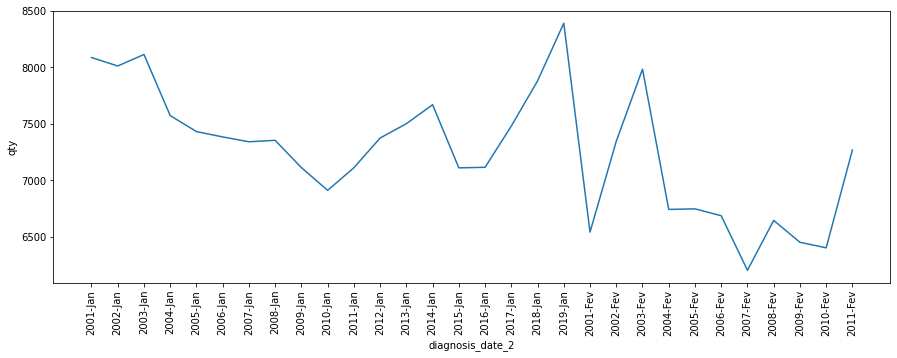

In [131]:
plt.figure(figsize=(15,5))

sns.lineplot(data=tuberculosis_melted[:30],
             x='diagnosis_date_2',
             y='qty')

plt.xticks(rotation=90);

- the date is not sorted, because it's a string not a date.

In [132]:
tuberculosis_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   year              228 non-null    object        
 1   month_pt          228 non-null    object        
 2   qty               228 non-null    int64         
 3   month             228 non-null    int64         
 4   diagnosis_date    228 non-null    datetime64[ns]
 5   diagnosis_date_2  228 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 10.8+ KB


- my solution solve this problem because I created a datetime column.

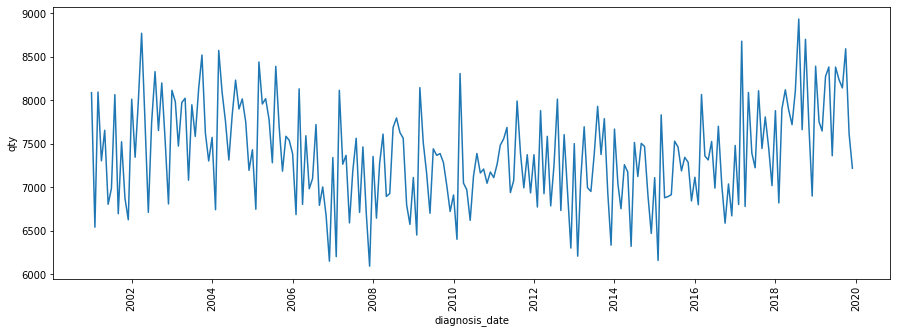

In [133]:
plt.figure(figsize=(15,5))

sns.lineplot(data=tuberculosis_melted,
             x='diagnosis_date',
             y='qty')

plt.xticks(rotation=90);

### Challenge 02: Convert the diagnosis_date_2 into datetime format.

My Challenge 01 solution already solve this problem. However, to practice, let's convert the column into datetime format.

In [134]:
def pt_date_str_to_datetime_object(year_month: str):
    return dateparser.parse(year_month+'/1', languages=['pt'])

tuberculosis_melted['diagnosis_date_3'] = \
    tuberculosis_melted['diagnosis_date_2'].map(pt_date_str_to_datetime_object)

tuberculosis_melted.head()

year month_pt   qty  month diagnosis_date diagnosis_date_2 diagnosis_date_3
0  2001      Jan  8088      1     2001-01-01         2001-Jan       2001-01-01
1  2002      Jan  8013      1     2002-01-01         2002-Jan       2002-01-01
2  2003      Jan  8115      1     2003-01-01         2003-Jan       2003-01-01
3  2004      Jan  7574      1     2004-01-01         2004-Jan       2004-01-01
4  2005      Jan  7432      1     2005-01-01         2005-Jan       2005-01-01

In [135]:
tuberculosis_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   year              228 non-null    object        
 1   month_pt          228 non-null    object        
 2   qty               228 non-null    int64         
 3   month             228 non-null    int64         
 4   diagnosis_date    228 non-null    datetime64[ns]
 5   diagnosis_date_2  228 non-null    object        
 6   diagnosis_date_3  228 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 12.6+ KB


# Lesson 2 - Manipulating Data - datetime format

How the teachers solved the problem of convert the month from Portuguese to English.

I already did it through `dateparser.parse`.

In [136]:
month_pt_en = {
    'Jan': 'Jan',
    'Fev': 'Feb',
    'Mar': 'Mar',
    'Abr': 'Apr',
    'Mai': 'May',
    'Jun': 'Jun',
    'Jul': 'Jul',
    'Ago': 'Aug',
    'Set': 'Sep',
    'Out': 'Oct',
    'Nov': 'Nov',
    'Dez': 'Dec'
}


tuberculosis_melted['month_pt'].map(month_pt_en)

# create a column with the month in English
# join the strings year and month in English
# use pd.to_datetime() in the column with the strings added

0      Jan
1      Jan
2      Jan
3      Jan
4      Jan
      ... 
223    Dec
224    Dec
225    Dec
226    Dec
227    Dec
Name: month_pt, Length: 228, dtype: object

In [137]:
# solution from discord

# !locale-gen "pt_BR.UTF-8"

# import locale
# locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# pd.to_datetime(tuberculosis_melted['diagnosis_date_2'], format='%Y-%b')

In [138]:
tuberculosis_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   year              228 non-null    object        
 1   month_pt          228 non-null    object        
 2   qty               228 non-null    int64         
 3   month             228 non-null    int64         
 4   diagnosis_date    228 non-null    datetime64[ns]
 5   diagnosis_date_2  228 non-null    object        
 6   diagnosis_date_3  228 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 12.6+ KB


In [139]:
tuberculosis_ts = tuberculosis_melted[['diagnosis_date', 'qty']].copy()

tuberculosis_ts.head()

diagnosis_date   qty
0     2001-01-01  8088
1     2002-01-01  8013
2     2003-01-01  8115
3     2004-01-01  7574
4     2005-01-01  7432

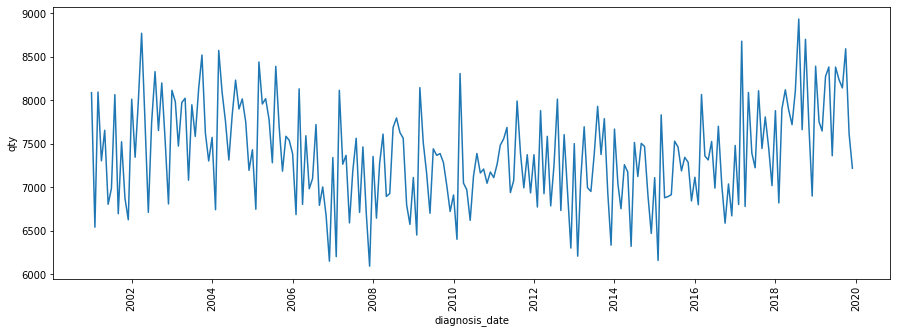

In [140]:
plt.figure(figsize=(15,5))

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='qty')

plt.xticks(rotation=90);

### Challenge 01: Reproduce the code above (convert str to datetime) with another dataset - leprosy.

- Getting the data

In [141]:
url_leprosy = 'https://raw.githubusercontent.com/gabrielatrindade/alura-bootcamp/master/module4/data/A123202189_28_143_208.csv'

leprosy = pd.read_csv(url_leprosy, encoding='ISO-8859-1',
                      sep=';', skiprows=3,
                      skipfooter=10, engine='python',
                      na_values='-')

leprosy.drop('Total', axis=1, inplace=True)
leprosy.drop(46, inplace=True)
leprosy.drop(0, inplace=True)
leprosy.reset_index(drop=True, inplace=True)


leprosy.tail()

Ano Diagnóstico     Jan     Fev     Mar     Abr     Mai     Jun     Jul  \
40            2015  2729.0  2969.0  3476.0  2930.0  3017.0  2969.0  3018.0   
41            2016  2393.0  2540.0  3000.0  2702.0  2616.0  2957.0  2603.0   
42            2017  2585.0  2718.0  3162.0  2557.0  3243.0  2806.0  2739.0   
43            2018  2971.0  2877.0  3276.0  3157.0  3237.0  2913.0  2976.0   
44            2019  3105.0  3319.0  2804.0  3037.0  3047.0  2567.0  2856.0   

       Ago     Set     Out     Nov     Dez  
40  3244.0  3241.0  3075.0  2819.0  2412.0  
41  3113.0  2881.0  2644.0  2528.0  2213.0  
42  3288.0  2856.0  3275.0  2961.0  2448.0  
43  3644.0  3274.0  3423.0  2909.0  2268.0  
44  3107.0  3060.0  3137.0  2715.0  1886.0

- Manipulating it

In [142]:
leprosy_melted = (leprosy.melt(id_vars='Ano Diagnóstico',
                              value_name='cases',
                              var_name='month_pt')
                         .rename(columns={'Ano Diagnóstico' : 'year'}))

leprosy_melted.reset_index(drop=True, inplace=True)

leprosy_melted

year month_pt   cases
0    1975      Jan     NaN
1    1976      Jan     NaN
2    1977      Jan     2.0
3    1978      Jan     NaN
4    1979      Jan     2.0
..    ...      ...     ...
535  2015      Dez  2412.0
536  2016      Dez  2213.0
537  2017      Dez  2448.0
538  2018      Dez  2268.0
539  2019      Dez  1886.0

[540 rows x 3 columns]

- Creating datetime column

In [143]:
leprosy_melted['month'] = leprosy_melted['month_pt'].map(pt_month_str_to_datetime_object)
leprosy_melted['date'] = pd.to_datetime(leprosy_melted[['year', 'month']].assign(Day=1))

leprosy_melted

year month_pt   cases  month       date
0    1975      Jan     NaN      1 1975-01-01
1    1976      Jan     NaN      1 1976-01-01
2    1977      Jan     2.0      1 1977-01-01
3    1978      Jan     NaN      1 1978-01-01
4    1979      Jan     2.0      1 1979-01-01
..    ...      ...     ...    ...        ...
535  2015      Dez  2412.0     12 2015-12-01
536  2016      Dez  2213.0     12 2016-12-01
537  2017      Dez  2448.0     12 2017-12-01
538  2018      Dez  2268.0     12 2018-12-01
539  2019      Dez  1886.0     12 2019-12-01

[540 rows x 5 columns]

- Selecting the columns, sorting the values

In [144]:
leprosy_ts = leprosy_melted[['date', 'cases']] \
                  .copy() \
                  .sort_values('date', ascending=True) \
                  .reset_index(drop=True) \
        
        
        
leprosy_ts.head()

date  cases
0 1975-01-01    NaN
1 1975-02-01    1.0
2 1975-03-01    NaN
3 1975-04-01    NaN
4 1975-05-01    NaN

- Fill null values

In [145]:
leprosy_ts['cases'].fillna(method='backfill', inplace=True)
leprosy_ts

date   cases
0   1975-01-01     1.0
1   1975-02-01     1.0
2   1975-03-01     1.0
3   1975-04-01     1.0
4   1975-05-01     1.0
..         ...     ...
535 2019-08-01  3107.0
536 2019-09-01  3060.0
537 2019-10-01  3137.0
538 2019-11-01  2715.0
539 2019-12-01  1886.0

[540 rows x 2 columns]

### Challenge 02: Improve the line plot.

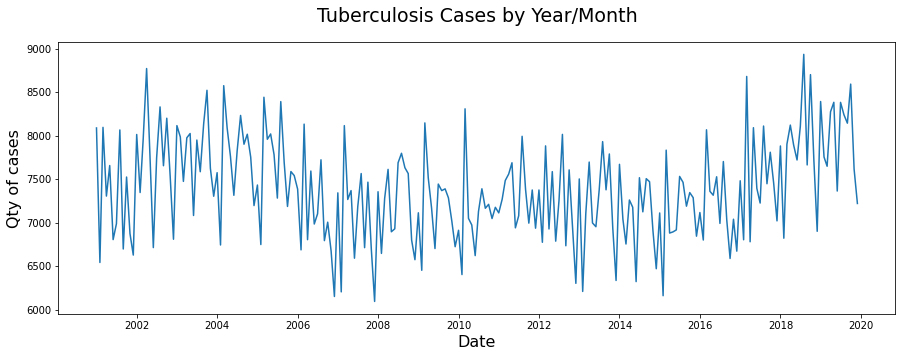

In [146]:
plt.figure(figsize=(15,5))

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='qty')

plt.xlabel('Date', fontsize=16)
plt.ylabel('Qty of cases', fontsize=16)
plt.title('Tuberculosis Cases by Year/Month', fontsize=19, pad=20);

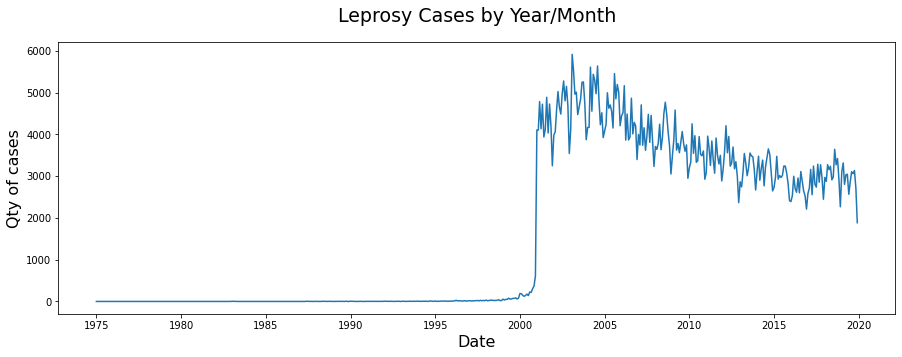

In [147]:
plt.figure(figsize=(15,5))

sns.lineplot(data=leprosy_ts,
             x='date',
             y='cases')

plt.xlabel('Date', fontsize=16)
plt.ylabel('Qty of cases', fontsize=16)
plt.title('Leprosy Cases by Year/Month', fontsize=19, pad=20);

# Lesson 3 - Starting time series analysis -  Trends and moving average

**Challenge 01: Search about frequency spectrum**

- to analyse the curve trends, we calculate the moving average

In [148]:
# calculate 'qty' every 3 months
tuberculosis_ts['qty'].rolling(3)

Rolling [window=3,center=False,axis=0]

In [149]:
# sum qty every 3 months
tuberculosis_ts['qty'].rolling(3).sum()

0          NaN
1          NaN
2      24216.0
3      23702.0
4      23121.0
        ...   
223    19649.0
224    19986.0
225    20536.0
226    20592.0
227    21140.0
Name: qty, Length: 228, dtype: float64

In [150]:
tuberculosis_ts['moving_average_3'] = \
    tuberculosis_ts['qty'].rolling(3).mean()
    
tuberculosis_ts['moving_average_3']

0              NaN
1              NaN
2      8072.000000
3      7900.666667
4      7707.000000
          ...     
223    6549.666667
224    6662.000000
225    6845.333333
226    6864.000000
227    7046.666667
Name: moving_average_3, Length: 228, dtype: float64

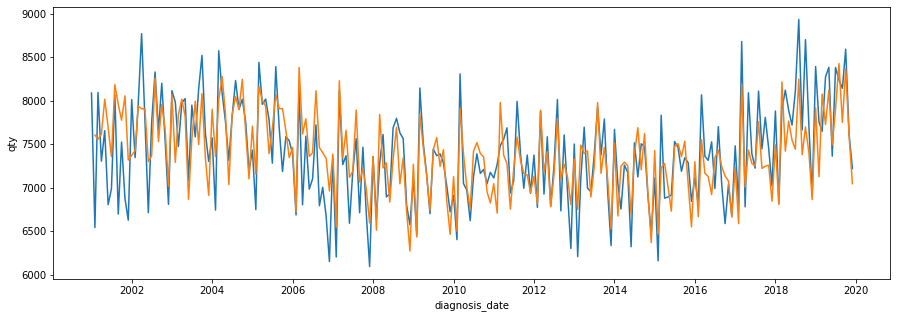

In [151]:
plt.figure(figsize=(15,5))

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='qty')

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='moving_average_3');

It's not possible analyse trends through the graph above

Let's try the same with a different rolling

In [152]:
tuberculosis_ts['moving_average_6'] = \
    tuberculosis_ts['qty'].rolling(6).mean()

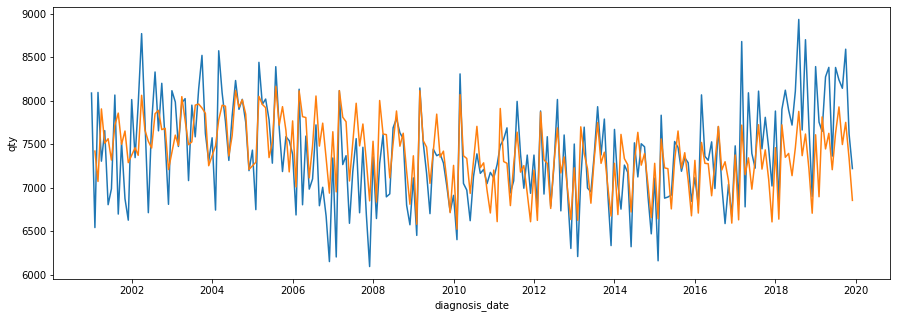

In [153]:
plt.figure(figsize=(15,5))

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='qty')

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='moving_average_6');

### NOTE: Why does it not work well even with  rolling=6?
Because our dataset is not sorted by date, and the 'rolling' will consider the average by the index.

### Let's correct it. Recalculate the moving average. And plot again.

In [154]:
tuberculosis_ts.head()

diagnosis_date   qty  moving_average_3  moving_average_6
0     2001-01-01  8088               NaN               NaN
1     2002-01-01  8013               NaN               NaN
2     2003-01-01  8115       8072.000000               NaN
3     2004-01-01  7574       7900.666667               NaN
4     2005-01-01  7432       7707.000000               NaN

In [155]:
tuberculosis_ts.sort_values('diagnosis_date', inplace=True)
tuberculosis_ts.reset_index(drop=True, inplace=True)
tuberculosis_ts

diagnosis_date   qty  moving_average_3  moving_average_6
0       2001-01-01  8088               NaN               NaN
1       2001-02-01  6542       7605.000000       7420.500000
2       2001-03-01  8095       7556.666667       7072.166667
3       2001-04-01  7305       7618.000000       7905.666667
4       2001-05-01  7656       8017.000000       7511.833333
..             ...   ...               ...               ...
223     2019-08-01  8239       8427.666667       7928.666667
224     2019-09-01  8143       7751.000000       7496.166667
225     2019-10-01  8592       8367.333333       7750.833333
226     2019-11-01  7615       7592.333333       7334.666667
227     2019-12-01  7220       7046.666667       6854.333333

[228 rows x 4 columns]

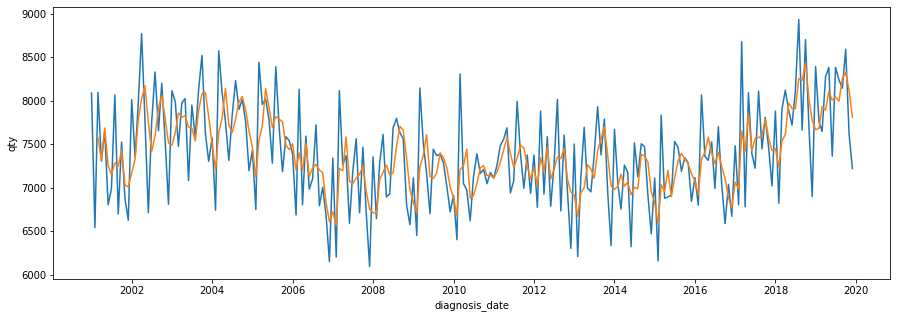

In [156]:
tuberculosis_ts['moving_average_3'] = \
    tuberculosis_ts['qty'].rolling(3).mean()

plt.figure(figsize=(15,5))

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='qty')

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='moving_average_3');

In the graph, some peaks in the moving average line are happening after the cases line

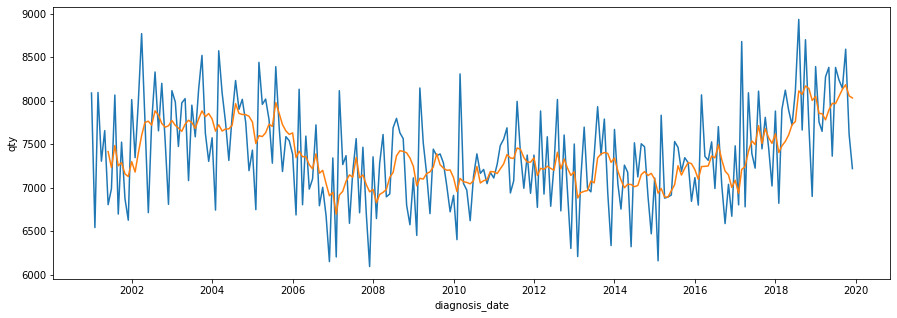

In [157]:
tuberculosis_ts['moving_average_6'] = \
    tuberculosis_ts['qty'].rolling(6).mean()

plt.figure(figsize=(15,5))

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='qty')

sns.lineplot(data=tuberculosis_ts,
             x='diagnosis_date',
             y='moving_average_6');

the moving average smoothes the graph curve

to see the spikes better:

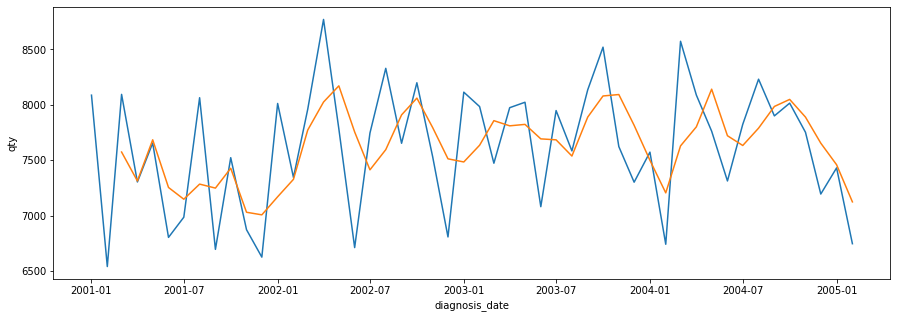

In [158]:
plt.figure(figsize=(15,5))


sns.lineplot(data=tuberculosis_ts[:50],
             x='diagnosis_date',
             y='qty')

sns.lineplot(data=tuberculosis_ts[:50],
             x='diagnosis_date',
             y='moving_average_3');

- Let's try to correct the peaks of moving average according to the peaks of cases.

### centered moving average

In [159]:
tuberculosis_ts['moving_average_3_c'] = \
    tuberculosis_ts['qty'].rolling(3, center=True).mean()

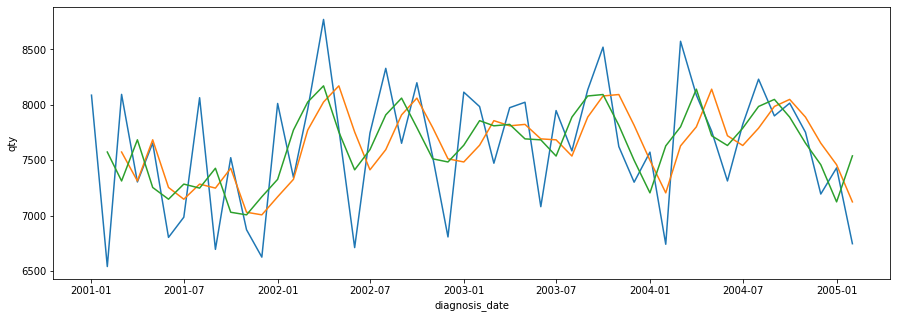

In [160]:
plt.figure(figsize=(15,5))


sns.lineplot(data=tuberculosis_ts[:50],
             x='diagnosis_date',
             y='qty')

sns.lineplot(data=tuberculosis_ts[:50],
             x='diagnosis_date',
             y='moving_average_3');

sns.lineplot(data=tuberculosis_ts[:50],
             x='diagnosis_date',
             y='moving_average_3_c');

**Challenge 02: Analyse the moving average with another period.**

**Challenge 03: Make your first prediction - use the averages (all data, or 3 last months).**

### Challenge 01: Search about frequency spectrum

http://web.stanford.edu/class/earthsys214/notes/series.html#a-simple-example

https://www2.mps.mpg.de/homes/lagg/talks/2004_IMPRS_spectral_analysis/span.pdf

### Challenge 02: Analyse the moving average with another period / window.

In [161]:
def lineplot_tuberculosis_cases_moving_average(rolling: int):
    
    df = tuberculosis_ts[['diagnosis_date', 'qty']].copy()
    df['moving_average_c'] = df['qty'].rolling(rolling, center=True).mean()
    
    plt.figure(figsize=(15,5))

    sns.lineplot(data=df,
                 x='diagnosis_date',
                 y='qty',
                 alpha=0.7,
                 label='cases')

    sns.lineplot(data=df,
                 x='diagnosis_date',
                 y='moving_average_c',
                 linewidth=1.9,
                 label='moving average - rolling '+str(rolling)
                 );

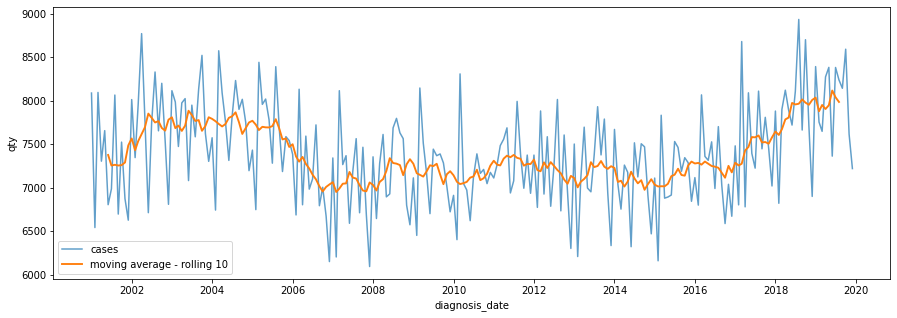

In [162]:
lineplot_tuberculosis_cases_moving_average(10)

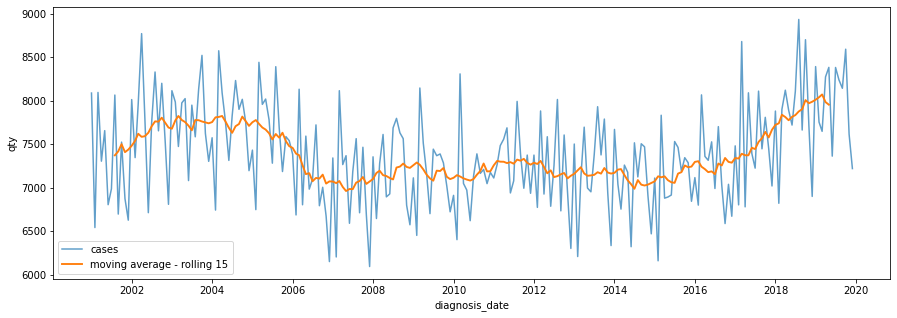

In [163]:
lineplot_tuberculosis_cases_moving_average(15)

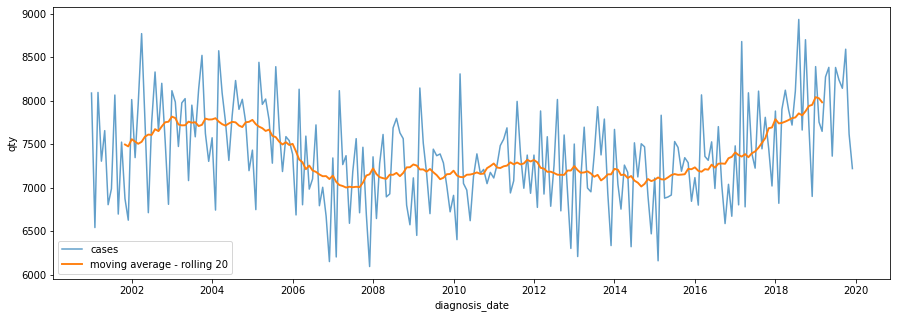

In [164]:
lineplot_tuberculosis_cases_moving_average(20)

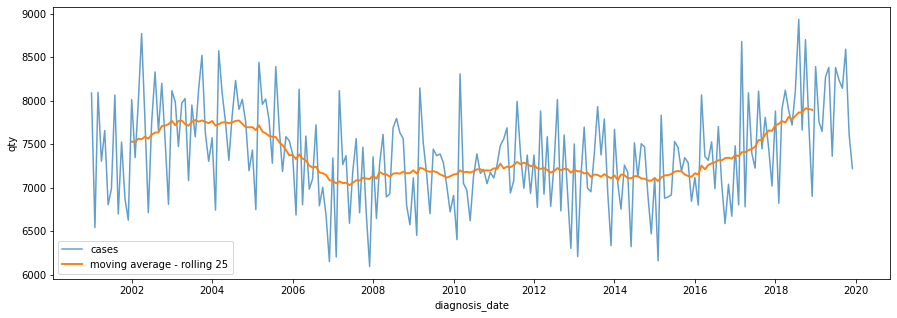

In [165]:
lineplot_tuberculosis_cases_moving_average(25)

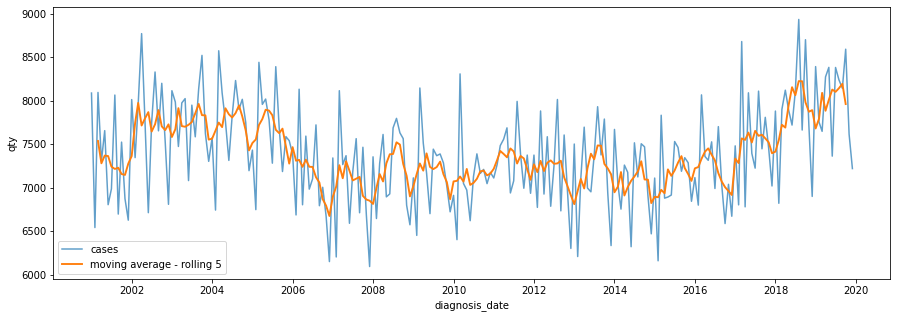

In [166]:
lineplot_tuberculosis_cases_moving_average(5)

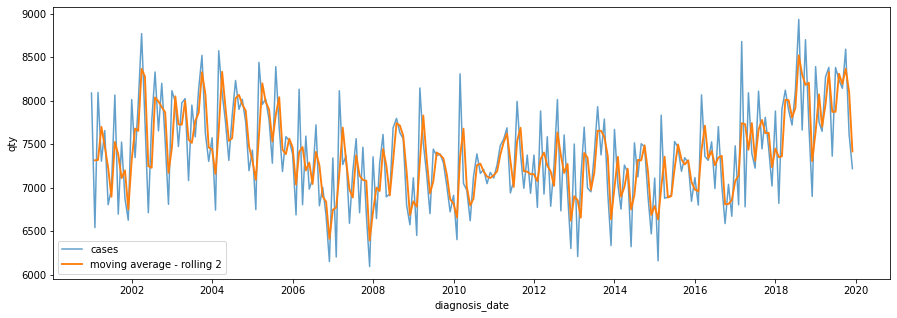

In [167]:
lineplot_tuberculosis_cases_moving_average(2)

### Challenge 03: Make your first prediction - use the averages (all data, or 3 last months).

code from: https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

In [168]:
# prepare situation
X = tuberculosis_ts['qty'].values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=7575.000000, expected=7305.000000
predicted=7314.000000, expected=7656.000000
predicted=7685.333333, expected=6805.000000
predicted=7255.333333, expected=6987.000000
predicted=7149.333333, expected=8065.000000
predicted=7285.666667, expected=6697.000000
predicted=7249.666667, expected=7524.000000
predicted=7428.666667, expected=6874.000000
predicted=7031.666667, expected=6627.000000
predicted=7008.333333, expected=8013.000000
predicted=7171.333333, expected=7346.000000
predicted=7328.666667, expected=7961.000000
predicted=7773.333333, expected=8771.000000
predicted=8026.000000, expected=7784.000000
predicted=8172.000000, expected=6713.000000
predicted=7756.000000, expected=7746.000000
predicted=7414.333333, expected=8330.000000
predicted=7596.333333, expected=7654.000000
predicted=7910.000000, expected=8200.000000
predicted=8061.333333, expected=7532.000000
predicted=7795.333333, expected=6809.000000
predicted=7513.666667, expected=8115.000000
predicted=7485.333333, expected=

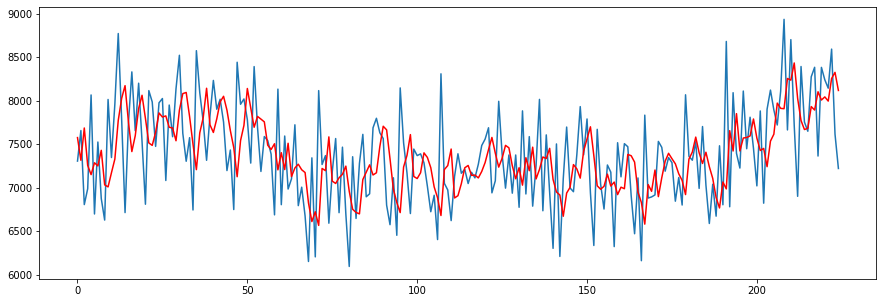

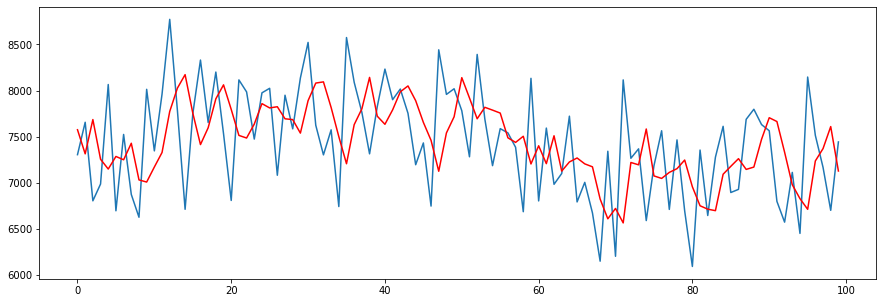

In [169]:
# plot
plt.figure(figsize=(15,5))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# zoom plot
plt.figure(figsize=(15,5))

plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.show()

# Lesson 4 - Decomposition and Autocorrelation

---

# Lesson 4 - part 01 - Finding Patterns

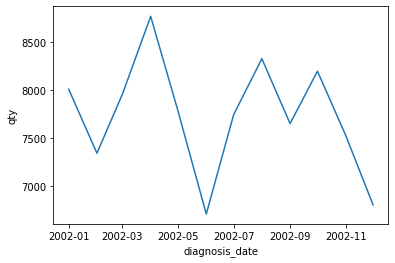

In [170]:
sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_ts[12:24]);

**Challenge 01: Set the date as index and then make slices through the date.**

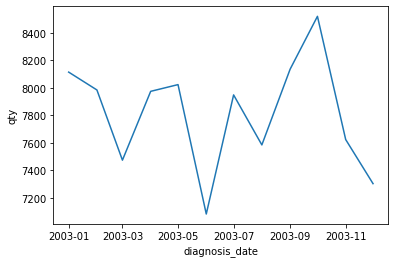

In [171]:
sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_ts[24:36]);

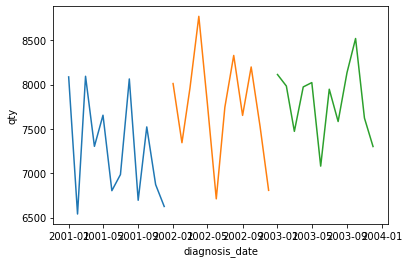

In [172]:
sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_ts[:12]);

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_ts[12:24]);

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_ts[24:36]);

- note: the lines didn't overlap

I want to compare the lines for each year... is there some pattern?

In [173]:
tuberculosis_ts.head()

diagnosis_date   qty  moving_average_3  moving_average_6  moving_average_3_c
0     2001-01-01  8088               NaN               NaN                 NaN
1     2001-02-01  6542               NaN               NaN         7575.000000
2     2001-03-01  8095       7575.000000               NaN         7314.000000
3     2001-04-01  7305       7314.000000               NaN         7685.333333
4     2001-05-01  7656       7685.333333               NaN         7255.333333

In [174]:
tuberculosis_ts['month'] = \
    tuberculosis_ts['diagnosis_date'].dt.month

tuberculosis_ts['year'] = \
    tuberculosis_ts['diagnosis_date'].dt.year

In [175]:
tuberculosis_ts.head()

diagnosis_date   qty  moving_average_3  moving_average_6  \
0     2001-01-01  8088               NaN               NaN   
1     2001-02-01  6542               NaN               NaN   
2     2001-03-01  8095       7575.000000               NaN   
3     2001-04-01  7305       7314.000000               NaN   
4     2001-05-01  7656       7685.333333               NaN   

   moving_average_3_c  month  year  
0                 NaN      1  2001  
1         7575.000000      2  2001  
2         7314.000000      3  2001  
3         7685.333333      4  2001  
4         7255.333333      5  2001

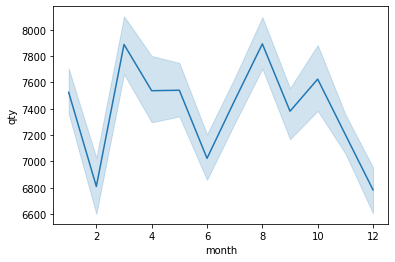

In [176]:
sns.lineplot(x='month',
             y='qty',
             data=tuberculosis_ts);

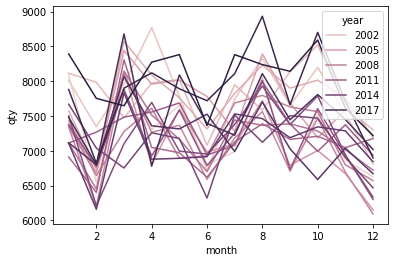

In [177]:
sns.lineplot(x='month',
             y='qty',
             data=tuberculosis_ts,
             hue='year');

**Challenge 02: Improve the graph above. Use another color palette.**

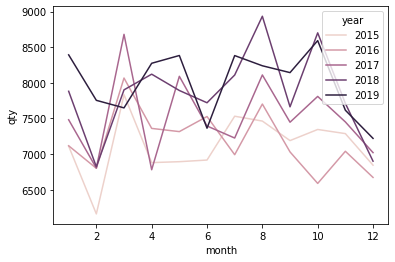

In [178]:
sns.lineplot(x='month',
             y='qty',
             data=tuberculosis_ts.query('year in [2019, 2018, 2017, 2016, 2015]'),
             hue='year');

- Analysing time series...
- Trying to find patterns...

stats models: https://www.statsmodels.org/stable/tsa.html

In [179]:
decomposition = \
    seasonal_decompose(tuberculosis_ts[['diagnosis_date', 'qty']]
                           .set_index('diagnosis_date'))

decomposition

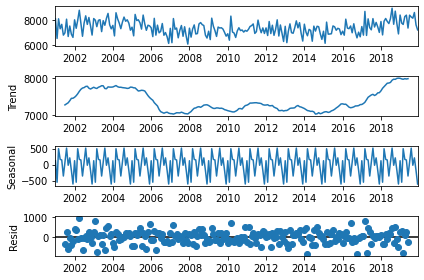

In [180]:
decomposition.plot();

- The first graph is 'observed'

**Challenge 03: Study about the graph below. How to combine the curves and generate the series.**

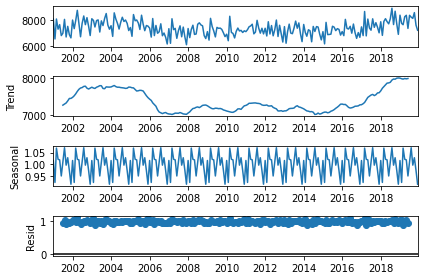

In [181]:
decomposition_multiplicative = \
    seasonal_decompose(tuberculosis_ts[['diagnosis_date', 'qty']]
                           .set_index('diagnosis_date'),
                       model='multiplicative')

decomposition_multiplicative.plot();

- With the residual lower we can better explain the time series used. This indicates that our time series has a multiplicative model.

- Multiplicative model: it creates the observed curve through the multiplication of trend and seasonal and residual.
- Adictive model: it creates the observed curve through the sum of trend and seasonal and residual.


As the residual value is almost 1, this multiplicative model cannot say too much about as well because everything I multiplies per 1, is itself.



http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf

### Challenge 01: Set the date as index and then make slices through the date.

In [182]:
tuberculosis_ts.set_index('diagnosis_date', inplace=True)

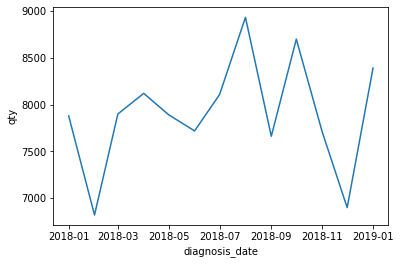

In [183]:
sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_ts['2018-01-01':'2019-01-01']);

### Challenge 02: Improve the graph above. Use another color palette.

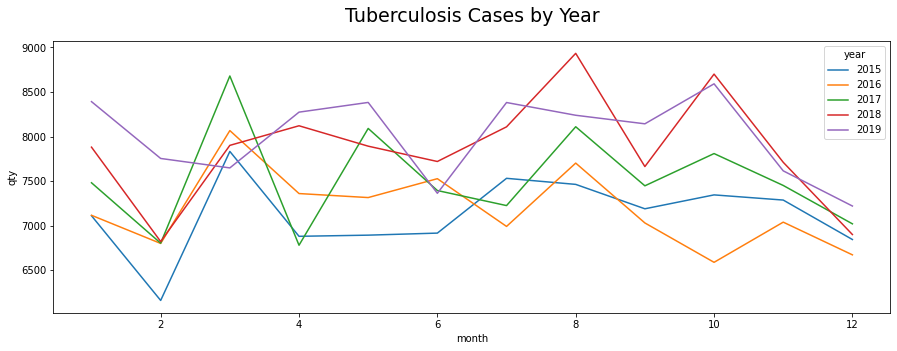

In [184]:
plt.figure(figsize=(15,5))

sns.lineplot(x='month',
             y='qty',
             data=tuberculosis_ts.query('year in [2019, 2018, 2017, 2016, 2015]'),
             hue='year',
             palette="tab10")

plt.title('Tuberculosis Cases by Year', fontsize=19, pad=19);

### Challenge 03: Study about the graph below. How to combine the curves and generate the series.

- Observated: Observed data

- Trend: The estimated trend component

- Seasonal: The estimated seasonal component

- Residual: The estimated residuals


[/wikipedia](https://en.wikipedia.org/wiki/Decomposition_of_time_series):
Decomposition based on rates of change
This is an important technique for all types of time series analysis, especially for seasonal adjustment. It seeks to construct, from an observed time series, a number of component series (that could be used to reconstruct the original by additions or multiplications) where each of these has a certain characteristic or type of behavior. For example, time series are usually decomposed into:
- $T_c$, the trend component at time t, which reflects the long-term progression of the series (secular variation). A trend exists when there is a persistent increasing or decreasing direction in the data. The trend component does not have to be linear.
- $C_t$, the cyclical component at time t, which reflects repeated but non-periodic fluctuations. The duration of these fluctuations depend on the nature of the time series.
- $S_t$, the seasonal component at time t, reflecting seasonality (seasonal variation). A seasonal pattern exists when a time series is influenced by seasonal factors. Seasonality occurs over a fixed and known period (e.g., the quarter of the year, the month, or day of the week).
- $I_t$, the irregular component (or "noise") at time t, which describes random, irregular influences. It represents the residuals or remainder of the time series after the other components have been removed.

Hence a time series using an additive model can be thought of as <br>
$y_{t}=T_{t}+C_{t}+S_{t}+I_{t}$, <br>

whereas a multiplicative model would be <br>
$y_{t}=T_{t}\times C_{t}\times S_{t}\times I_{t}$

Sometimes the trend and cyclical components are grouped into one, called the trend-cycle component. The trend-cycle component can just be referred to as the "trend" component, even though it may contain cyclical behavior.

https://medium.com/swlh/time-series-seasonal-decomposition-a300fe0f34dd

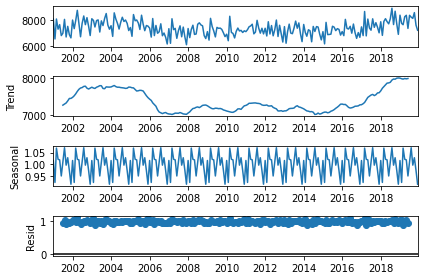

In [185]:
decomposition_multiplicative.plot();

# Lesson 4 - part 02 - Decomposition of Time Series

- analysing another example

In [186]:
url_passengers = 'https://raw.githubusercontent.com/alura-cursos/serie_temporal_bootcamp/main/AirPassengers.csv'

passengers = pd.read_csv(url_passengers)
passengers.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [187]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [188]:
passengers['Month'] = pd.to_datetime(passengers['Month'])

passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


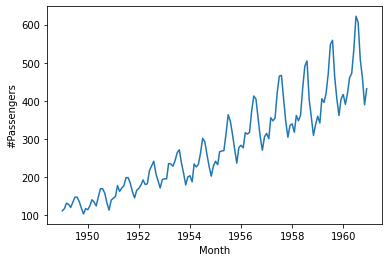

In [189]:
sns.lineplot(x='Month',
             y='#Passengers',
             data=passengers);

- We can see a trend and seasonality

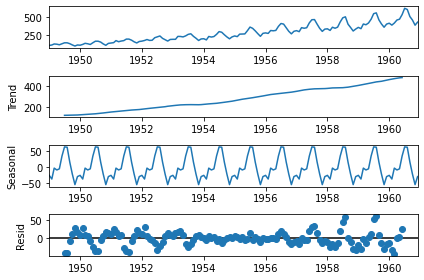

In [190]:
decomposition_passengers = \
    seasonal_decompose(passengers.set_index('Month'))

decomposition_passengers.plot();

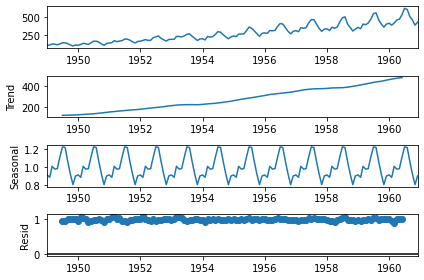

In [191]:
decomposition_passengers_multiplicative = \
    seasonal_decompose(passengers.set_index('Month'),
                       model='multiplicative')

decomposition_passengers_multiplicative.plot();

### Challenge 04: Improve the decomposition graphs.

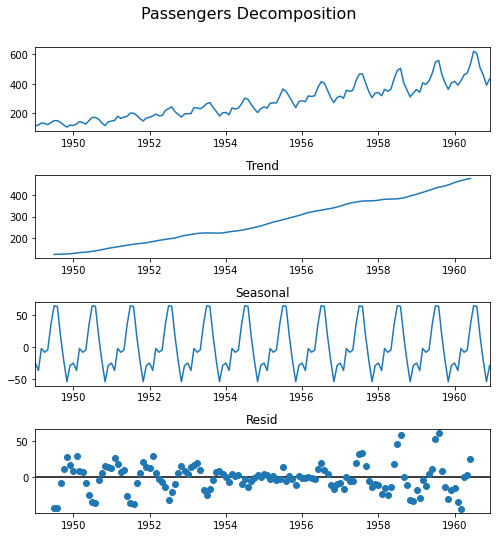

In [192]:
# plt.rcParams['figure.figsize'] = (9, 7)

fig = decomposition_passengers.plot();

fig.suptitle('Passengers Decomposition', fontsize=16, y=1.06)
fig.set_figheight(7)
fig.set_figwidth(7)

for i in range(4):
    fig.axes[i].set_title(fig.axes[i].get_ylabel())
    fig.axes[i].set_ylabel('')

fig.tight_layout()

### Challenge 05: Do the decomposition analysis for leprosy data.

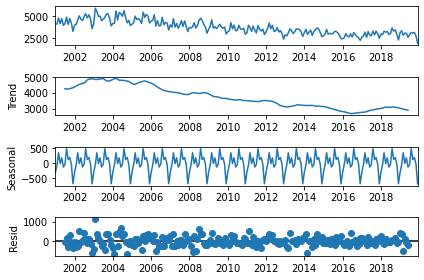

In [193]:
decomposition_leprosy_additive = \
    seasonal_decompose(leprosy_ts.query('date.dt.year > 2000')
                                 .set_index('date'))
    
decomposition_leprosy_additive.plot();

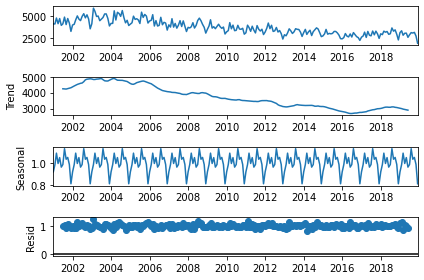

In [194]:
decomposition_leprosy_multiplicative = \
    seasonal_decompose(leprosy_ts.query('date.dt.year > 2000')
                                 .set_index('date'),
                       model='multiplicative')
    
decomposition_leprosy_multiplicative.plot();

# Lesson 4 - part 03 - Autocorrelation and Parcial Autocorrelation

https://www.tylervigen.com/spurious-correlations

cross correlation: two variables.

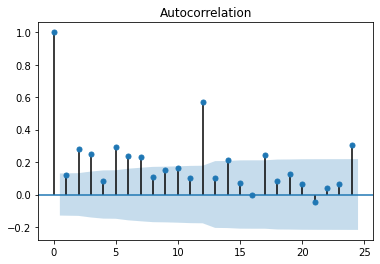

In [195]:
plot_acf(tuberculosis_ts['qty']);

y-axis: indicates the autocorrelation value
x-axis: lags for the analysis correlation

for example, when the lag is 0 it means that we are compare the correlation between my serie with itself, so the value is 1.
with the lag equals 12 we have a high correlation.


For those ones that are above the confidence level, we considerate that it's something correlated. On the other hand, for those ones that are inside the confidence level cloud can be a random factor.

**Challenge 06: Make the autocorrelation and parcial autocorrelation analysis in the covid-19 cases.**

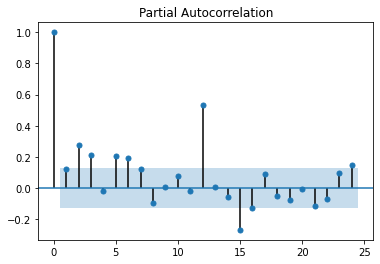

In [196]:
plot_pacf(tuberculosis_ts['qty']);

parcial autocorrelation: normalized according to lag equals 1.

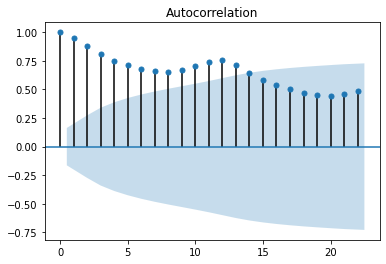

In [197]:
plot_acf(passengers['#Passengers']);

we can notice a seasonality.

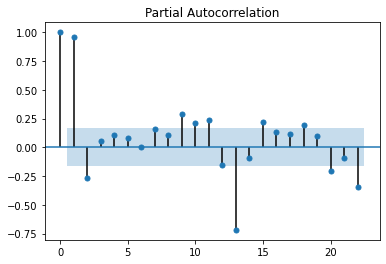

In [198]:
plot_pacf(passengers['#Passengers']);

**Challenge 07: Make the autocorrelation and parcial autocorrelation analysis in the leprosy cases.**

### Challenge 06: Make the autocorrelation and parcial autocorrelation analysis in the covid-19 cases.

In [199]:
url_covid = 'https://github.com/alura-cursos/agendamento-hospitalar/blob/main/dados/COVID19-BRASILIO-06-11-2020.csv.gz?raw=true'

covid = pd.read_csv(url_covid, compression='gzip')

covid.head()

date state city place_type  confirmed  deaths  order_for_place  \
0  2020-11-05    AC  NaN      state      31248     697              234   
1  2020-11-04    AC  NaN      state      31218     696              233   
2  2020-11-03    AC  NaN      state      30962     695              232   
3  2020-11-02    AC  NaN      state      30954     693              231   
4  2020-11-01    AC  NaN      state      30951     693              230   

   is_last  estimated_population_2019  estimated_population  city_ibge_code  \
0     True                   881935.0              894470.0            12.0   
1    False                   881935.0              894470.0            12.0   
2    False                   881935.0              894470.0            12.0   
3    False                   881935.0              894470.0            12.0   
4    False                   881935.0              894470.0            12.0   

   confirmed_per_100k_inhabitants  death_rate  
0                      3493.46540      0.0223  
1                      3490.11146      0.0223  
2                      3461.49116      0.0224  
3                      3460.59678      0.0224  
4                      3460.26138      0.0224

In [200]:
covid['date'] = pd.to_datetime(covid['date'])

covid_rn = covid[(covid.state == 'RN') & 
                 (covid.place_type == 'state')] \
                .copy()

covid_rn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 566774 to 566985
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            212 non-null    datetime64[ns]
 1   state                           212 non-null    object        
 2   city                            0 non-null      object        
 3   place_type                      212 non-null    object        
 4   confirmed                       212 non-null    int64         
 5   deaths                          212 non-null    int64         
 6   order_for_place                 212 non-null    int64         
 7   is_last                         212 non-null    bool          
 8   estimated_population_2019       212 non-null    float64       
 9   estimated_population            212 non-null    float64       
 10  city_ibge_code                  212 non-null    float64       
 11

In [206]:
covid_rn.head()

covid_rn.sort_values('date', inplace=True)

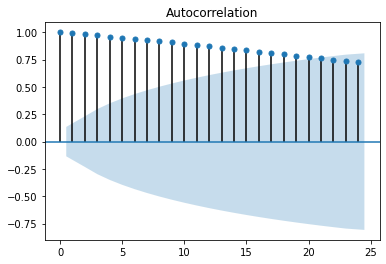

In [207]:
plot_acf(covid_rn['confirmed']);

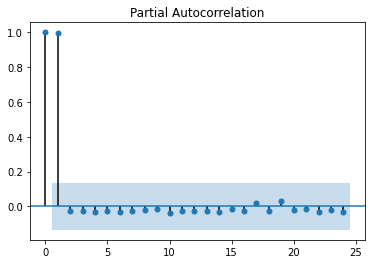

In [208]:
plot_pacf(covid_rn['confirmed']);

### Challenge 07: Make the autocorrelation and parcial autocorrelation analysis in the leprosy cases.

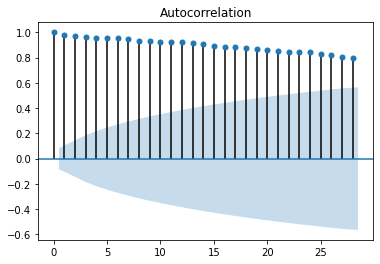

In [209]:
plot_acf(leprosy_ts['cases']);

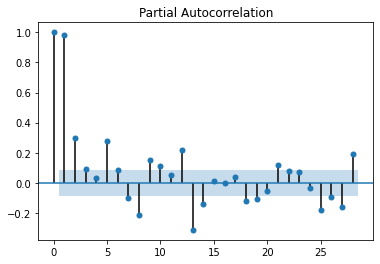

In [210]:
plot_pacf(leprosy_ts['cases']);

# Lesson 5 - Predictions in Time Series

---

# Lesson 5 - part 01 - Recap concepts

In [211]:
passengers.head()

Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121

In [212]:
passengers.rename({'Month': 'Date'}, axis=1, inplace=True)

In [213]:
passengers['Month'] = passengers['Date'].dt.month
passengers['Year'] = passengers['Date'].dt.year


passengers.head()

Date  #Passengers  Month  Year
0 1949-01-01          112      1  1949
1 1949-02-01          118      2  1949
2 1949-03-01          132      3  1949
3 1949-04-01          129      4  1949
4 1949-05-01          121      5  1949

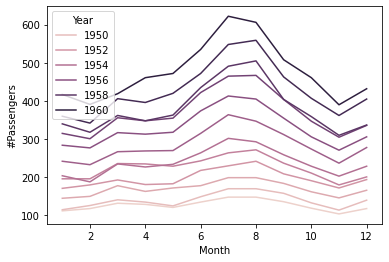

In [214]:
sns.lineplot(x='Month',
             y='#Passengers',
             data=passengers,
             hue='Year');

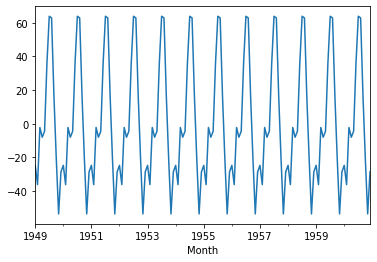

In [215]:
decomposition_passengers.seasonal.plot();

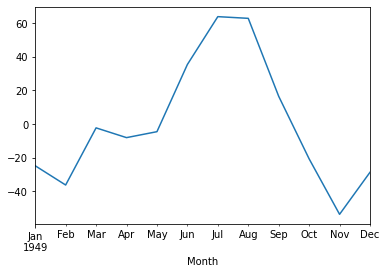

In [216]:
decomposition_passengers.seasonal[0:12].plot();

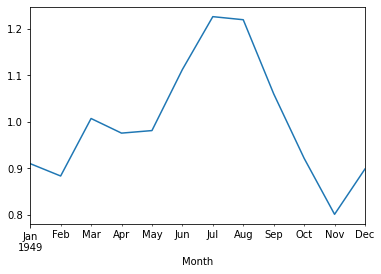

In [217]:
decomposition_passengers_multiplicative.seasonal[0:12].plot();

- If I wouldn't have seasonality in the muttiplicative decomposition, the line would be close to 1.0.

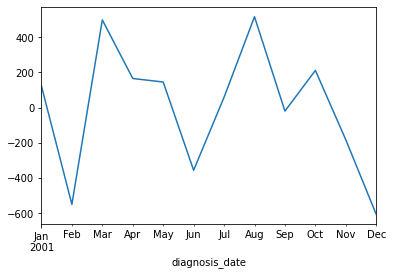

In [218]:
decomposition.seasonal[0:12].plot();

- Keep in mind that the graph above represents just one year

# Lesson 5 - part 02 - Time series prediction: ARIMA


AutoRegressive Integrated Moving Average model

In [219]:
arima_model = ARIMA_D(tuberculosis_ts['qty'].values.astype('float32'), 
                    order=[0, 0, 0])

arima_model_trained = arima_model.fit()

/home/gabriela/.local/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [220]:
arima_model_trained

In [221]:
arima_model_trained.forecast(12)

(array([7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
        7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
        7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772]),
 array([567.21170306, 567.21170306, 567.21170306, 567.21170306,
        567.21170306, 567.21170306, 567.21170306, 567.21170306,
        567.21170306, 567.21170306, 567.21170306, 567.21170306]),
 array([[6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734]]))

In [222]:
arima_model_trained.forecast(12)[0]

array([7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
       7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
       7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772])

It's returning the mean of all time series.

**Challenge 01: Search what the order parameter means. Check if it returns the mean of all time series.**

In [223]:
tuberculosis_ts['qty'].mean()

7389.285087719299

**Challenge 02: Understanding the tuple returned by the forecast method. Plot it together with the forecast, prediction.**

Are we doing good predictions?!

In [224]:
tuberculosis_train = tuberculosis_ts.query('year != 2019').copy()
tuberculosis_test = tuberculosis_ts.query('year == 2019').copy()


arima_model_2 = ARIMA_D(tuberculosis_train['qty'].values.astype('float32'), 
                      order=[0, 0, 0])

arima_model_trained_2 = arima_model_2.fit()

prediction_tuberculosis = arima_model_trained_2.forecast(12)[0]

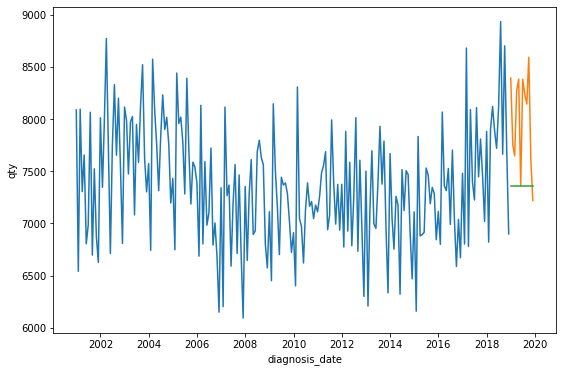

In [225]:
tuberculosis_test['prediction'] = prediction_tuberculosis

plt.figure(figsize=(9,6))

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_train)

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_test)

sns.lineplot(x='diagnosis_date',
             y='prediction',
             data=tuberculosis_test);

**Challenge 03: Make the same prediction above for the passengers dataset. Make changes on order parameter.**

### Challenge 01: Search what the order parameter means. Check if it returns the mean of all time series.

order: iterable <br>
The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

The (p,d,q) order of the model for the autoregressive, differences, and moving average components. d is always an integer, while p and q may either be integers or lists of integers.



In [226]:
arima_model_trained.forecast(12)[0]

array([7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
       7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
       7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772])

In [227]:
tuberculosis_ts['qty'].mean()

7389.285087719299

### Challenge 02: Understanding the tuple returned by the forecast method. Plot it together with the forecast, prediction.

Returns:
- *forecast: ndarray* <br>
Array of out of sample forecasts

- *stderr: ndarray* <br>
Array of the standard error of the forecasts.

- *conf_int: ndarray* <br>
2d array of the confidence interval for the forecast

In [228]:
arima_model_trained.forecast(12)[2]

array([[6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734],
       [6277.5705781 , 8500.99959734]])

In [229]:
tuberculosis_all_forecast = tuberculosis_ts[:12].copy()

tuberculosis_all_forecast['prediction'] = arima_model_trained.forecast(12)[0]
tuberculosis_all_forecast['stderr'] = arima_model_trained.forecast(12)[1]
tuberculosis_all_forecast['conf_interval_0'] = \
    [ arr[0] for arr in arima_model_trained.forecast(12)[2] ]
tuberculosis_all_forecast['conf_interval_1'] = \
    [ arr[1] for arr in arima_model_trained.forecast(12)[2] ]

tuberculosis_all_forecast.head()

qty  moving_average_3  moving_average_6  moving_average_3_c  \
diagnosis_date                                                                 
2001-01-01      8088               NaN               NaN                 NaN   
2001-02-01      6542               NaN               NaN         7575.000000   
2001-03-01      8095       7575.000000               NaN         7314.000000   
2001-04-01      7305       7314.000000               NaN         7685.333333   
2001-05-01      7656       7685.333333               NaN         7255.333333   

                month  year   prediction      stderr  conf_interval_0  \
diagnosis_date                                                          
2001-01-01          1  2001  7389.285088  567.211703      6277.570578   
2001-02-01          2  2001  7389.285088  567.211703      6277.570578   
2001-03-01          3  2001  7389.285088  567.211703      6277.570578   
2001-04-01          4  2001  7389.285088  567.211703      6277.570578   
2001-05-01          5  2001  7389.285088  567.211703      6277.570578   

                conf_interval_1  
diagnosis_date                   
2001-01-01          8500.999597  
2001-02-01          8500.999597  
2001-03-01          8500.999597  
2001-04-01          8500.999597  
2001-05-01          8500.999597

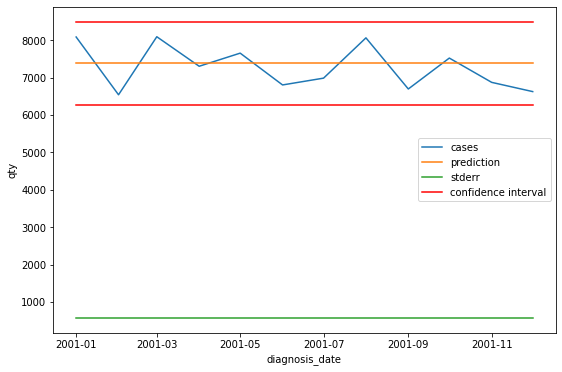

In [230]:
plt.figure(figsize=(9,6))

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_all_forecast,
             label='cases')

sns.lineplot(x='diagnosis_date',
             y='prediction',
             data=tuberculosis_all_forecast,
             label='prediction')

sns.lineplot(x='diagnosis_date',
             y='stderr',
             data=tuberculosis_all_forecast,
             label='stderr')

sns.lineplot(x='diagnosis_date',
             y='conf_interval_0',
             data=tuberculosis_all_forecast,
             label='confidence interval', 
             color='red')

sns.lineplot(x='diagnosis_date',
             y='conf_interval_1',
             data=tuberculosis_all_forecast,
             color='red')


plt.show()

### Challenge 03: Make the same prediction above for the passengers dataset. Make changes on order parameter.

In [231]:
passengers.tail()

Date  #Passengers  Month  Year
139 1960-08-01          606      8  1960
140 1960-09-01          508      9  1960
141 1960-10-01          461     10  1960
142 1960-11-01          390     11  1960
143 1960-12-01          432     12  1960

In [232]:
passengers_train = passengers[passengers.Year != 1960].copy()
passengers_test = passengers[passengers.Year == 1960].copy()

arima_model_passengers = ARIMA(passengers_train['#Passengers'].values.astype('float32'),
                               order=[2,3,7], enforce_stationarity=False, 
                               enforce_invertibility=False)

arima_model_passengers_trained = arima_model_passengers.fit()

arima_model_passengers_trained.forecast(12)

/home/gabriela/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


array([402.97096614, 334.01169306, 309.98509135, 300.91450552,
       320.74781892, 332.15877919, 321.48381942, 301.70362019,
       288.15702049, 282.5630476 , 277.29371552, 266.88972799])

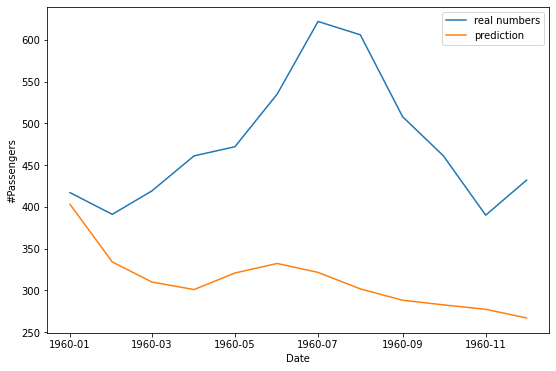

In [233]:
passengers_forecast = passengers_test.copy()
passengers_forecast['prediction'] = arima_model_passengers_trained.forecast(12)

plt.figure(figsize=(9,6))


sns.lineplot(data=passengers_forecast,
             x='Date',
             y='#Passengers',
             label='real numbers')

sns.lineplot(data=passengers_forecast,
             x='Date',
             y='prediction',
             label='prediction');

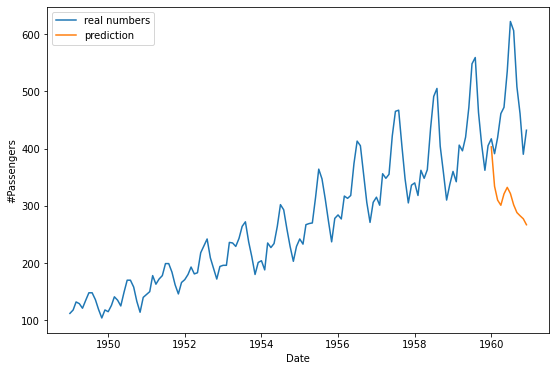

In [234]:
plt.figure(figsize=(9,6))


sns.lineplot(data=passengers,
             x='Date',
             y='#Passengers',
             label='real numbers')

sns.lineplot(data=passengers_forecast,
             x='Date',
             y='prediction',
             label='prediction');

# Lesson 5 - part 03 - Adjusting parameters

https://www.mathworks.com/help/econ/autocorrelation-and-partial-autocorrelation.html

- AR: autoregressive

In [235]:
arima_model_AR = ARIMA(tuberculosis_train['qty'].values.astype('float32'), 
                      order=[1, 0, 0])

arima_model_trained_AR = arima_model_AR.fit()

prediction_tuberculosis_AR = arima_model_trained_AR.forecast(12)

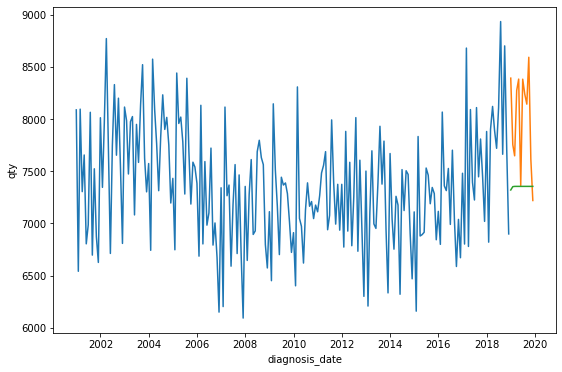

In [236]:
tuberculosis_test['prediction_AR'] = prediction_tuberculosis_AR

plt.figure(figsize=(9,6))

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_train)

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_test)

sns.lineplot(x='diagnosis_date',
             y='prediction_AR',
             data=tuberculosis_test);

In [237]:
prediction_tuberculosis_AR

array([7320.82493456, 7352.71804193, 7355.1351285 , 7355.31831251,
       7355.3321955 , 7355.33324765, 7355.33332739, 7355.33333344,
       7355.33333389, 7355.33333393, 7355.33333393, 7355.33333393])

- MA: moving average

In [238]:
# creating a model moving average of mean=1
arima_model_MA = ARIMA(tuberculosis_train['qty'].values.astype('float32'), 
                      order=[0, 0, 1])

arima_model_trained_MA = arima_model_MA.fit()

prediction_tuberculosis_MA = arima_model_trained_MA.forecast(12)

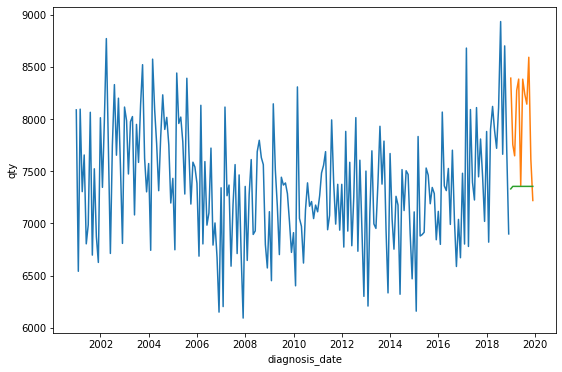

In [239]:
tuberculosis_test['prediction_MA'] = prediction_tuberculosis_MA

plt.figure(figsize=(9,6))

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_train)

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_test)

sns.lineplot(x='diagnosis_date',
             y='prediction_MA',
             data=tuberculosis_test);

In [240]:
prediction_tuberculosis_MA

array([7331.20141951, 7355.33333373, 7355.33333373, 7355.33333373,
       7355.33333373, 7355.33333373, 7355.33333373, 7355.33333373,
       7355.33333373, 7355.33333373, 7355.33333373, 7355.33333373])

- It changed just the first element



The ACF and PACF plots help us to define the parameter order (p,d,q).
See the table on the link https://www.mathworks.com/help/econ/autocorrelation-and-partial-autocorrelation.html

<br>
<br>


Os modelos - ARMA, AR, MA - assim que a série é estacionária

Serie temporal estacionária: significa que os pontos da série temporal flutuam ao redor de uma determinada média com uma variância constante. Dessa forma o modelo consegue garantir as características estatísticas para realizarem a previsão do modelo.

Quando não temos uma série temporal estacionária, o parametro d do Arima vai tratar de convertê-la.

In [241]:
arima_model_d = ARIMA(tuberculosis_train['qty'].values.astype('float32'), 
                      order=[0, 1, 1])

arima_model_trained_d = arima_model_d.fit()

prediction_tuberculosis_d = arima_model_trained_d.forecast(12)

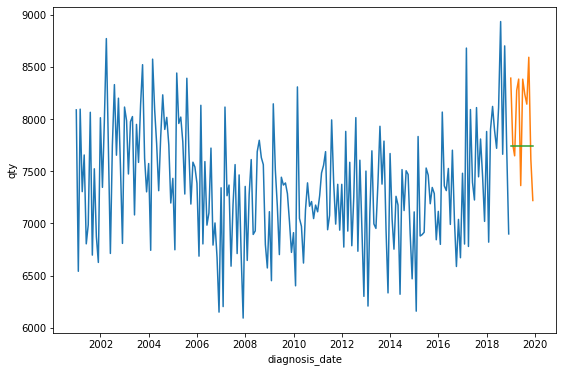

In [242]:
tuberculosis_test['prediction_d'] = prediction_tuberculosis_d

plt.figure(figsize=(9,6))

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_train)

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_test)

sns.lineplot(x='diagnosis_date',
             y='prediction_d',
             data=tuberculosis_test);

In [243]:
prediction_tuberculosis_d

array([7746.8142529, 7746.8142529, 7746.8142529, 7746.8142529,
       7746.8142529, 7746.8142529, 7746.8142529, 7746.8142529,
       7746.8142529, 7746.8142529, 7746.8142529, 7746.8142529])

Na série dos passageiros nós não temos um efeito estacionário. Os pontos não oscilam em cima de uma média, eles vão simplesmento crescente.

In [244]:
passengers.head()

Date  #Passengers  Month  Year
0 1949-01-01          112      1  1949
1 1949-02-01          118      2  1949
2 1949-03-01          132      3  1949
3 1949-04-01          129      4  1949
4 1949-05-01          121      5  1949

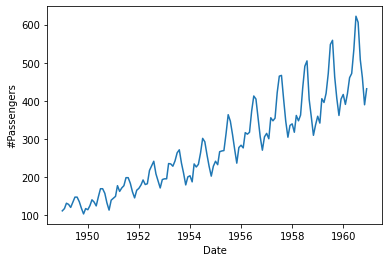

In [245]:
sns.lineplot(x='Date',
             y='#Passengers',
             data=passengers);

In [246]:
arima_model_passengers_2 = ARIMA(passengers_train['#Passengers'].values.astype('float32'),
                                 order=[0,0,0])

arima_model_passengers_trained_2 = arima_model_passengers_2.fit()

arima_model_passengers_trained_2.forecast(12)

array([262.49240358, 262.49240358, 262.49240358, 262.49240358,
       262.49240358, 262.49240358, 262.49240358, 262.49240358,
       262.49240358, 262.49240358, 262.49240358, 262.49240358])

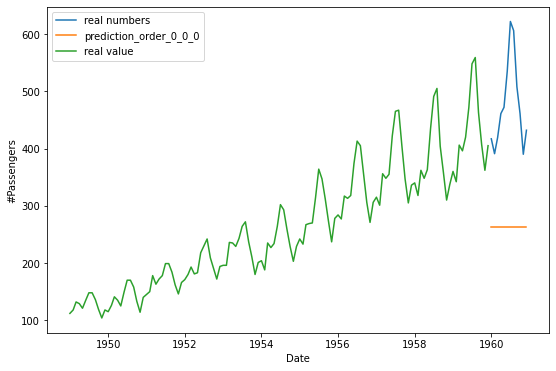

In [247]:
passengers_forecast['prediction_order_0_0_0'] = arima_model_passengers_trained_2.forecast(12)

plt.figure(figsize=(9,6))


sns.lineplot(data=passengers_forecast,
             x='Date',
             y='#Passengers',
             label='real numbers')

sns.lineplot(data=passengers_forecast,
             x='Date',
             y='prediction_order_0_0_0',
             label='prediction_order_0_0_0')

sns.lineplot(data=passengers_train,
             x='Date',
             y='#Passengers',
             label='real value');

In [248]:
def making_prediction_ARIMA(df_train: pd.DataFrame, df_test: pd.DataFrame, series: str, order: np.array):
    
    arima_model_df = ARIMA(df_train[series].values.astype('float32'),
                           order=order)

    arima_model_df_trained = arima_model_df.fit()

    forecast = arima_model_df_trained.forecast(12)
    
    df_test['prediction'] = forecast


def ploting_forecast(df_train: pd.DataFrame, df_test: pd.DataFrame, x: str, y: str):
    
    plt.figure(figsize=(9,6))

    sns.lineplot(x=x, y=y, data=df_train)

    sns.lineplot(x=x, y=y, data=df_test)

    sns.lineplot(x=x, y='prediction', data=df_test);

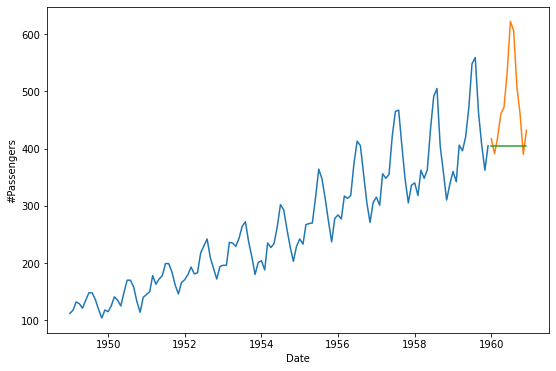

In [249]:
making_prediction_ARIMA(df_train=passengers_train,
                        df_test=passengers_test,
                        series='#Passengers',
                        order=[0,1,0])

ploting_forecast(df_train=passengers_train,
                 df_test=passengers_test,
                 x='Date',
                 y='#Passengers')

**Challenge 04: Visualize/plot differentiated (diff) time series in passengers dataset.**

**Challenge 05: Make the next analysis with the diff time series.**

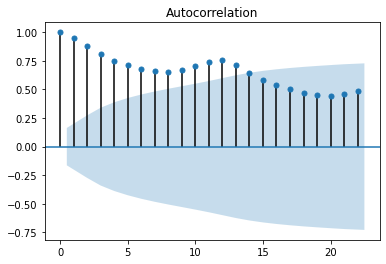

In [250]:
plot_acf(passengers['#Passengers']);

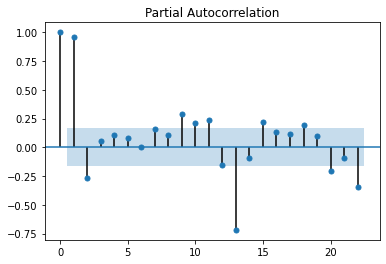

In [251]:
plot_pacf(passengers['#Passengers']);

- partial autocorrelation: lag 1, 3, 13
it determinates the p in order parameter in the ARIMA function - when we are looking at the AR autoregressive model.

Conditional Mean Model | ACF Behavior | _PACF Behavior_ <br>
AR(p), Tails off gradually, _Cuts off after p lags_ <br>
MA(q), Cuts off after q lags, Tails off gradually <br>
ARMA(p,q), Tails off gradually, Tails off gradually <br>

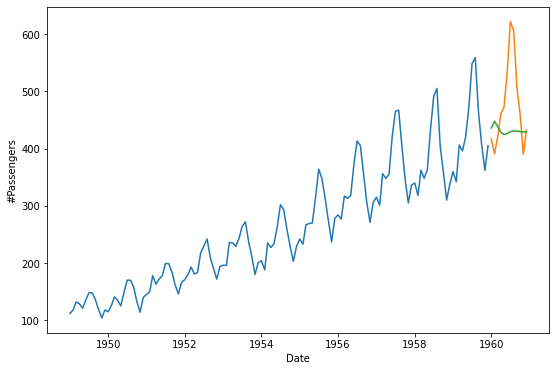

In [252]:
# p=3
making_prediction_ARIMA(df_train=passengers_train,
                        df_test=passengers_test,
                        series='#Passengers',
                        order=[3,1,0])

ploting_forecast(df_train=passengers_train,
                 df_test=passengers_test,
                 x='Date',
                 y='#Passengers')

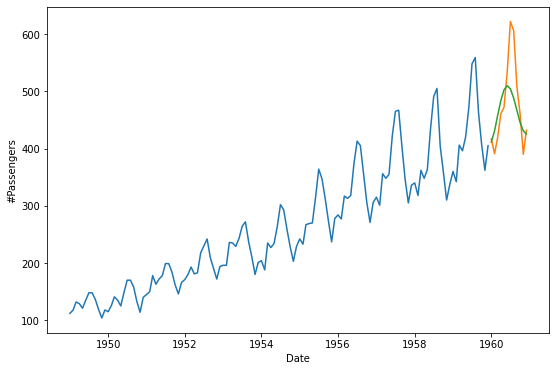

In [253]:
making_prediction_ARIMA(df_train=passengers_train,
                        df_test=passengers_test,
                        series='#Passengers',
                        order=[2,1,2])

ploting_forecast(df_train=passengers_train,
                 df_test=passengers_test,
                 x='Date',
                 y='#Passengers')

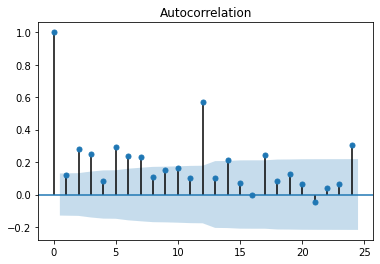

In [254]:
plot_acf(tuberculosis_ts['qty']);

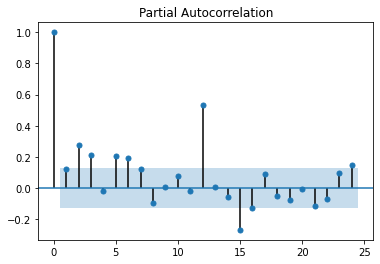

In [255]:
plot_pacf(tuberculosis_ts['qty']);

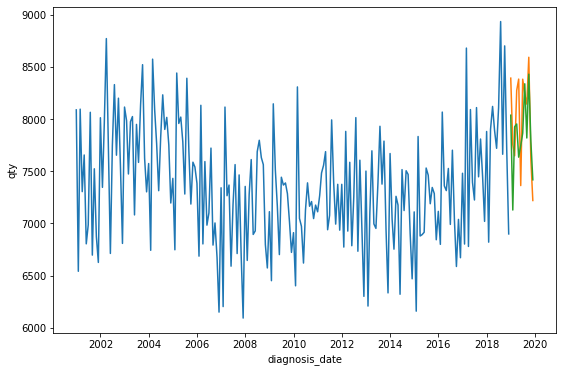

In [256]:
# p = lag = 12
making_prediction_ARIMA(df_train=tuberculosis_train,
                        df_test=tuberculosis_test,
                        series='qty',
                        order=[12,1,0])

ploting_forecast(df_train=tuberculosis_train,
                 df_test=tuberculosis_test,
                 x='diagnosis_date',
                 y='qty')

/home/gabriela/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


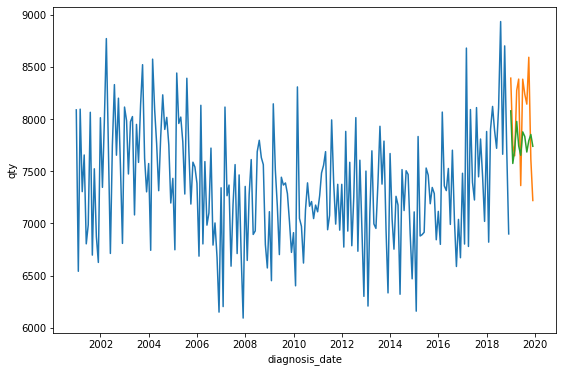

In [257]:
# p = lag = 3
making_prediction_ARIMA(df_train=tuberculosis_train,
                        df_test=tuberculosis_test,
                        series='qty',
                        order=[3,1,3])

ploting_forecast(df_train=tuberculosis_train,
                 df_test=tuberculosis_test,
                 x='diagnosis_date',
                 y='qty')

/home/gabriela/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


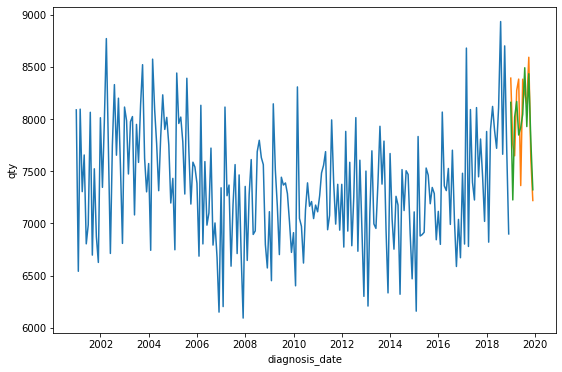

In [258]:
# p = lag = 12
making_prediction_ARIMA(df_train=tuberculosis_train,
                        df_test=tuberculosis_test,
                        series='qty',
                        order=[12,1,2])

ploting_forecast(df_train=tuberculosis_train,
                 df_test=tuberculosis_test,
                 x='diagnosis_date',
                 y='qty')

- These models are not considerated the seasonality of the dataset - passengers. And it's important.

### Challenge 04: Visualize/plot differentiated (diff) time series in passengers dataset.

In [259]:
passengers.head()

Date  #Passengers  Month  Year
0 1949-01-01          112      1  1949
1 1949-02-01          118      2  1949
2 1949-03-01          132      3  1949
3 1949-04-01          129      4  1949
4 1949-05-01          121      5  1949

In [260]:
passengers['Passengers_Diff'] = passengers['#Passengers'].diff().fillna(0)

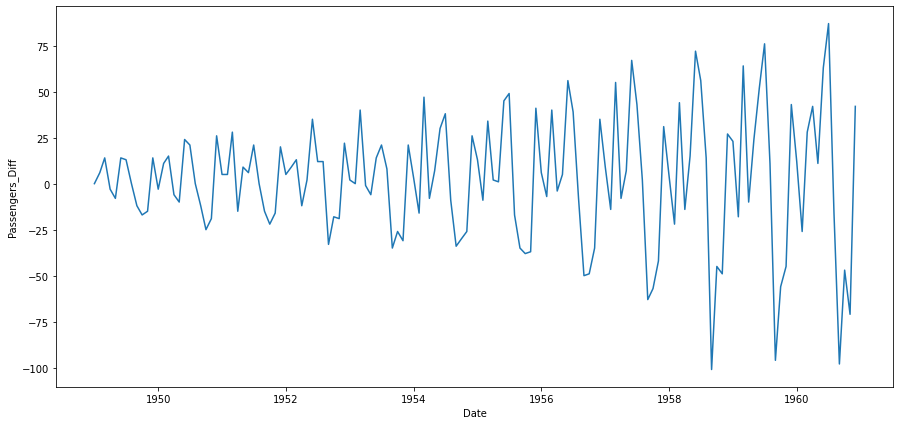

In [261]:
plt.figure(figsize=(15,7))

sns.lineplot(data=passengers,
             x='Date',
             y='Passengers_Diff');

### Challenge 05: Make the next analysis with the diff time series.

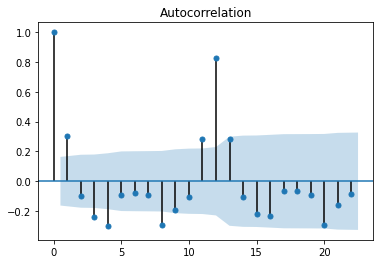

In [262]:
plot_acf(passengers['Passengers_Diff']);

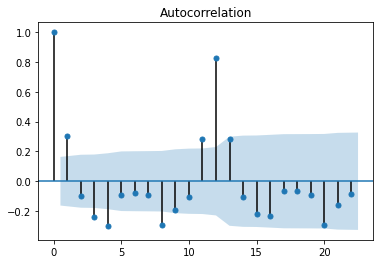

In [263]:
plot_acf(passengers['Passengers_Diff']);

/home/gabriela/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gabriela/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gabriela/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


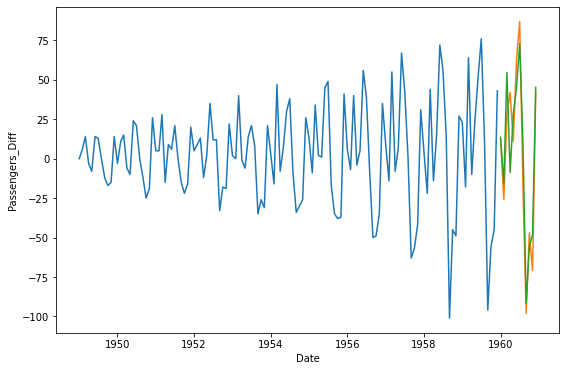

In [294]:
passengers_train_diff = passengers[passengers.Year != 1960].copy()
passengers_test_diff = passengers[passengers.Year == 1960].copy()


making_prediction_ARIMA(df_train=passengers_train_diff,
                        df_test=passengers_test_diff,
                        series='Passengers_Diff',
                        order=[12,1,2])

ploting_forecast(df_train=passengers_train_diff,
                 df_test=passengers_test_diff,
                 x='Date',
                 y='Passengers_Diff')

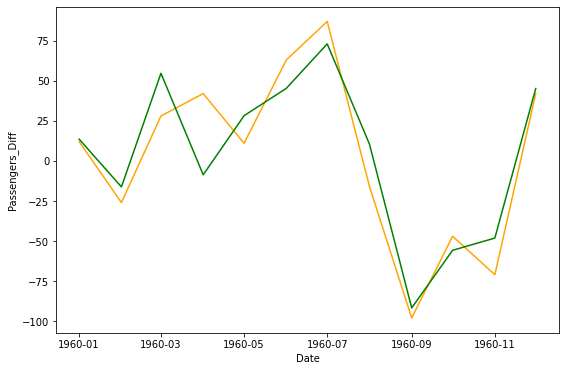

In [265]:
plt.figure(figsize=(9,6))

sns.lineplot(data=passengers_test_diff,
             x='Date',
             y='Passengers_Diff',
             color='orange')

sns.lineplot(data=passengers_test_diff,
             x='Date',
             y='prediction',
             color='green')

plt.show()

# Lesson 6 - AUTOARIMA e Prophet

---

# Lesson 6 - part 01 - Evaluation Metrics and AUTOARIMA

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

it will define the best order by itself

In [266]:
autoarima_model = auto_arima(tuberculosis_train['qty'].values,
                             error_action='ignore')

In [267]:
autoarima_model

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [268]:
autoarima_model = auto_arima(tuberculosis_train['qty'].values,
                             error_action='ignore', trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3366.610, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3312.298, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3460.524, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3309.482, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3310.770, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3311.065, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3310.088, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3344.652, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3307.835, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3310.594, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3364.610, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3309.098, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

- the lower AIC, the better is the model.
- seasonality is not being considerated = (0,0,0) in the model above.

In [269]:
autoarima_model

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**Challenge 01: Set max parameters - p, d, q.**

In [270]:
autoarima_model.predict(12)

array([7945.87236724, 7778.65152982, 7805.38787867, 7801.11309832,
       7801.79657785, 7801.68729872, 7801.70477097, 7801.7019774 ,
       7801.70242405, 7801.70235264, 7801.70236406, 7801.70236223])

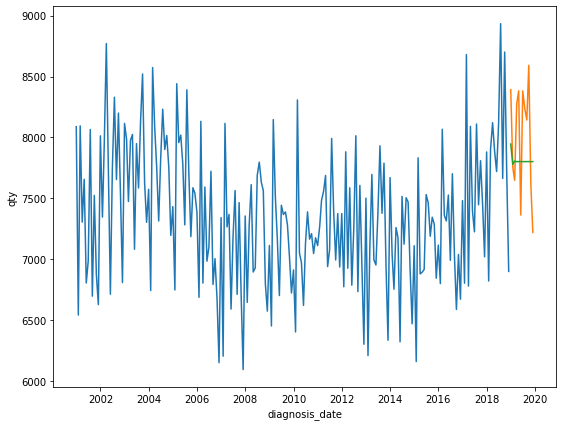

In [271]:
prediction_tuberculosis_autoarima = autoarima_model.predict(12)
tuberculosis_test['prediction_autoarima'] = prediction_tuberculosis_autoarima

plt.figure(figsize=(9,7))

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_train)

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_test)

sns.lineplot(x='diagnosis_date',
             y='prediction_autoarima',
             data=tuberculosis_test);

In [300]:
autoarima_model_seasonal = auto_arima(tuberculosis_train['qty'].values,
                                      error_action='ignore', trace=True,
                                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3289.199, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3249.086, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3460.524, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3312.298, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3246.454, Time=2.53 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3398.593, Time=1.52 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3242.479, Time=3.23 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.995, Time=1.33 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=3211.950, Time=5.10 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3204.771, Time=3.20 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept

- The result is different of Thiago/Allan results.

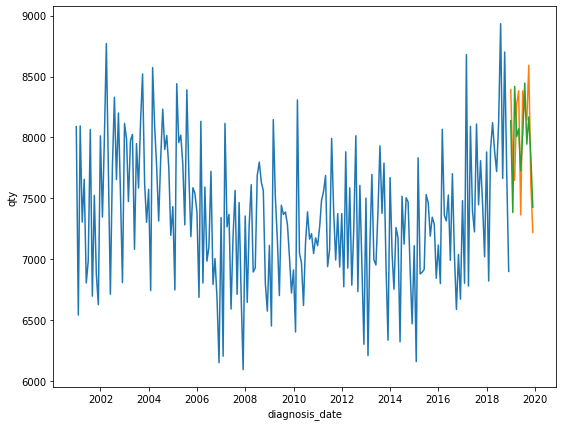

In [273]:
prediction_tuberculosis_autoarima = autoarima_model_seasonal.predict(12)
tuberculosis_test['prediction_autoarima_seasonal'] = prediction_tuberculosis_autoarima

plt.figure(figsize=(9,7))

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_train)

sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_test)

sns.lineplot(x='diagnosis_date',
             y='prediction_autoarima_seasonal',
             data=tuberculosis_test);

In [297]:
# let's create prediction_arima column with ARIMA_D as in the class
# the function that I've created uses ARIMA

# arima_model = ARIMA_D(tuberculosis_train['qty'].values.astype('float32'), 
#                       order=[12, 1, 2])

# arima_model_trained = arima_model.fit()

# prediction_tuberculosis = arima_model_trained.forecast(12)[0]

# tuberculosis_test['prediction_arima'] = prediction_tuberculosis

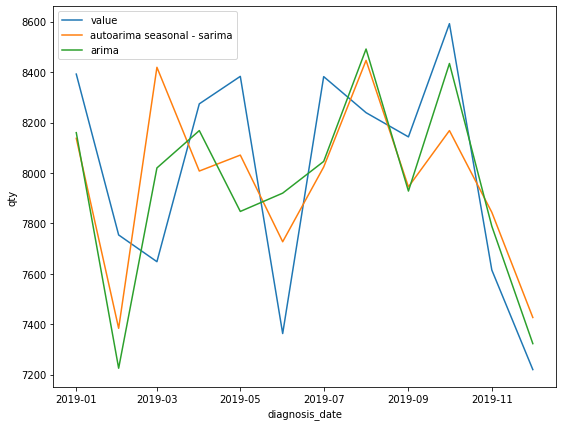

In [295]:
plt.figure(figsize=(9,7))
sns.lineplot(x='diagnosis_date',
             y='qty',
             data=tuberculosis_test,
             label='value')

sns.lineplot(x='diagnosis_date',
             y='prediction_autoarima_seasonal',
             data=tuberculosis_test,
             label='autoarima seasonal - sarima')

sns.lineplot(x='diagnosis_date',
             y='prediction',
             data=tuberculosis_test,
             label='arima');

**Challenge 02: Make the same analysis for leprosy and passengers.**

Let's compare the two models - sarima and arima - through mean squared error metric.


Evaluating the models:

In [299]:
mse_autoarima = mean_squared_error(tuberculosis_test['qty'],
                                   tuberculosis_test['prediction_autoarima_seasonal'])

mse_arima = mean_squared_error(tuberculosis_test['qty'],
                               tuberculosis_test['prediction'])


print(f'Autoarima = {mse_autoarima}')
print(f'Arima = {mse_arima}')

Autoarima = 131930.1761801522
Arima = 114057.32200940263


- the lower the mse, the better it will be.

**Challenge 03: Set different values in the parameters for the passengers data.**

### Challenge 01: Set max parameters - p, d, q.

In [303]:
autoarima_model_seasonal_max = \
    auto_arima(tuberculosis_train['qty'].values.astype('float32'),
               error_action='ignore', trace=True,
               seasonal=True, m=12, 
               max_p=12, max_d=5, max_q=7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3289.199, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3249.086, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3460.524, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3312.298, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3246.454, Time=2.62 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.85 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3398.593, Time=1.60 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3242.479, Time=3.30 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.995, Time=1.29 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=3211.950, Time=5.05 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3204.771, Time=3.22 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept

- It's not changing the results...

### Challenge 02: Make the same analysis for leprosy and passengers.

In [321]:
passengers_sarima = auto_arima(passengers_train['#Passengers'].values,
                               error_action='ignore', trace=True,
                               seasonal=True, m=12)

passengers_test['prediction_sarima'] = passengers_sarima.predict(12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.57 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=2.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.67 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.59 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.39 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.80 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.17 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.83 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

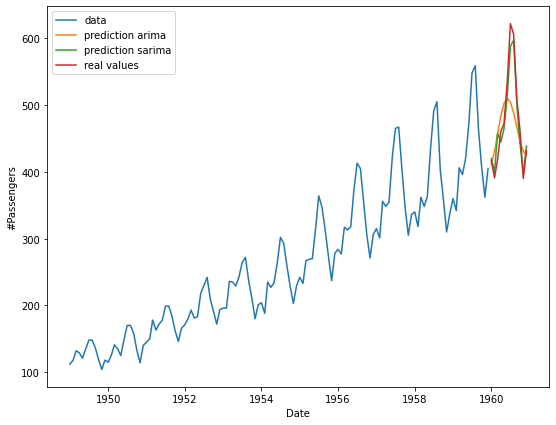

In [325]:
plt.figure(figsize=(9,7))

sns.lineplot(x='Date',
             y='#Passengers',
             data=passengers_train,
             label='data')

sns.lineplot(x='Date',
             y='prediction',
             data=passengers_test,
             label='prediction arima')

sns.lineplot(x='Date',
             y='prediction_sarima',
             data=passengers_test,
             label='prediction sarima')

sns.lineplot(x='Date',
             y='#Passengers',
             data=passengers_test,
             label='real values');

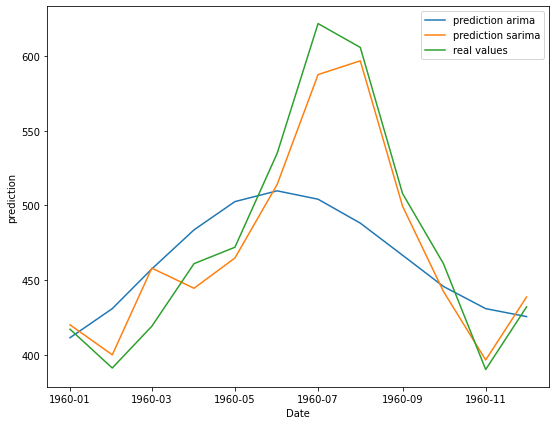

In [326]:
plt.figure(figsize=(9,7))

sns.lineplot(x='Date',
             y='prediction',
             data=passengers_test,
             label='prediction arima')

sns.lineplot(x='Date',
             y='prediction_sarima',
             data=passengers_test,
             label='prediction sarima')

sns.lineplot(x='Date',
             y='#Passengers',
             data=passengers_test,
             label='real values');

In [328]:
mse_arima = mean_squared_error(passengers_test['#Passengers'],
                               passengers_test['prediction'])

mse_sarima = mean_squared_error(passengers_test['#Passengers'],
                                passengers_test['prediction_sarima'])

print(f'Arima = {mse_arima}')
print(f'Sarima = {mse_sarima}')

Arima = 3049.561970169046
Sarima = 343.6006816829735


In [349]:
leprosy_train = leprosy_ts.query('date.dt.year != 2019 & date.dt.year > 2000').copy()
leprosy_test = leprosy_ts.query('date.dt.year == 2019 & date.dt.year > 2000').copy()

leprosy_sarima = auto_arima(leprosy_train['cases'].values,
                            error_action='ignore', trace=True,
                            seasonal=True, m=12)

leprosy_test['prediction_sarima'] = leprosy_sarima.predict(12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3141.958, Time=2.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3297.811, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3188.164, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3188.798, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3295.873, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=6.05 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=5.73 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3229.028, Time=0.50 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=4.85 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=6.25 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=3140.470, Time=2

In [375]:
leprosy_model_arima = ARIMA(leprosy_train['cases'].values, 
                            order=[3,1,5])

leprosy_model_trained_arima = leprosy_model_arima.fit()

leprosy_test['prediction_arima'] = leprosy_model_trained_arima.forecast(12)

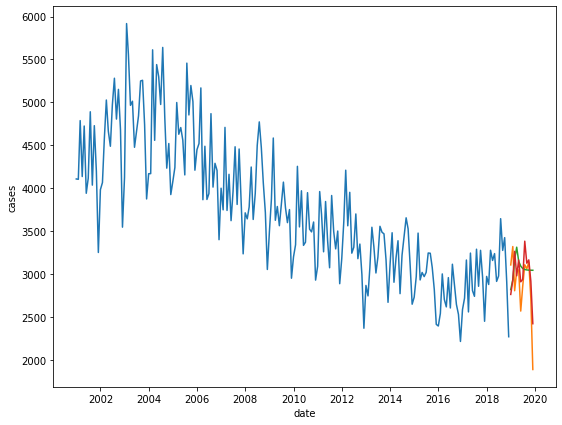

In [376]:
plt.figure(figsize=(9,7))


sns.lineplot(x='date', y='cases', data=leprosy_train)

sns.lineplot(x='date', y='cases', data=leprosy_test)

sns.lineplot(x='date', y='prediction_arima', data=leprosy_test)

sns.lineplot(x='date', y='prediction_sarima', data=leprosy_test);

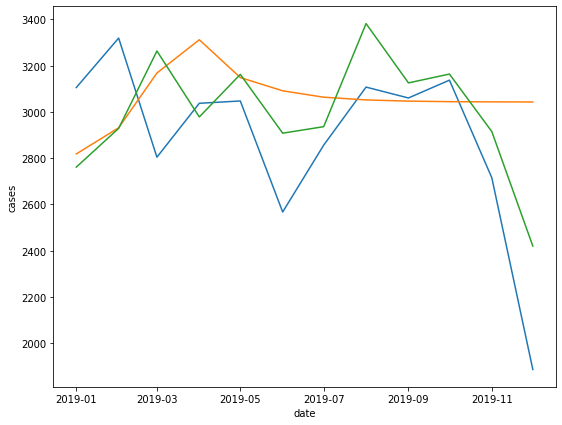

In [377]:
plt.figure(figsize=(9,7))

sns.lineplot(x='date', y='cases', data=leprosy_test)

sns.lineplot(x='date', y='prediction_arima', data=leprosy_test)

sns.lineplot(x='date', y='prediction_sarima', data=leprosy_test);

In [378]:
mse_arima = mean_squared_error(leprosy_test['cases'],
                               leprosy_test['prediction_arima'])

mse_sarima = mean_squared_error(leprosy_test['cases'],
                                leprosy_test['prediction_sarima'])

print(f'Arima = {mse_arima}')
print(f'Sarima = {mse_sarima}')

Arima = 185489.9436622917
Sarima = 85499.65733660091


### Challenge 03: Set different values in the parameters for the passengers data.

I already did it in the challenge 1, and it didn't work...

In [406]:
passengers_sarima = auto_arima(passengers_train['#Passengers'].values,
                               error_action='ignore', trace=True,
                               seasonal=True, m=12,
                               max_p=12, max_d=5, max_q=7)

passengers_test['prediction_sarima_2'] = passengers_sarima.predict(12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=4.04 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.80 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.65 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.48 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=1.02 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.15 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.86 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

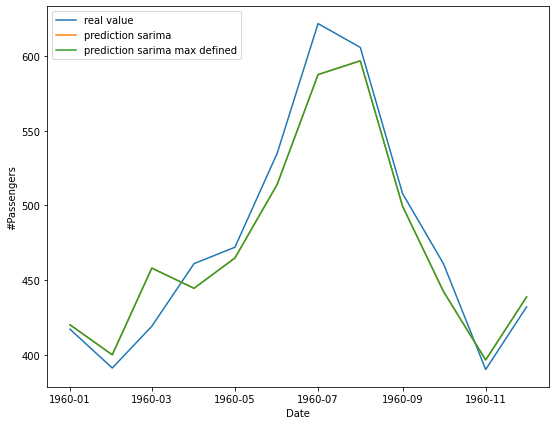

In [409]:
plt.figure(figsize=(9,7))

sns.lineplot(x='Date',
             y='#Passengers',
             data=passengers_test,
             label='real value')

sns.lineplot(x='Date',
             y='prediction_sarima',
             data=passengers_test,
             label='prediction sarima')

sns.lineplot(x='Date',
             y='prediction_sarima_2',
             data=passengers_test,
             label='prediction sarima max defined');

# Lesson 6 - part 02 - Forecasting with Prophet

https://facebook.github.io/prophet/

In [397]:
prophet_model = Prophet()

passengers_train_prophet = \
    (passengers_train[['Date', '#Passengers']]
         .copy()
         .rename(columns={'Date':'ds', 
                          '#Passengers':'y'}))

trained_prophet_model = prophet_model.fit(passengers_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [415]:
future = trained_prophet_model.make_future_dataframe(periods=12, freq='M')

future

ds
0   1949-01-01
1   1949-02-01
2   1949-03-01
3   1949-04-01
4   1949-05-01
..         ...
139 1960-07-31
140 1960-08-31
141 1960-09-30
142 1960-10-31
143 1960-11-30

[144 rows x 1 columns]

In [399]:
prediction_prophet = trained_prophet_model.predict(future)

prediction_prophet

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1949-01-01  108.446107   57.252119  107.466348   108.446107   108.446107   
1   1949-02-01  110.624181   49.346233  102.010364   110.624181   110.624181   
2   1949-03-01  112.591474   90.055497  142.124818   112.591474   112.591474   
3   1949-04-01  114.769548   82.763415  134.295225   114.769548   114.769548   
4   1949-05-01  116.877362   86.750862  135.950047   116.877362   116.877362   
..         ...         ...         ...         ...          ...          ...   
139 1960-07-31  467.254909  507.728917  555.941740   467.029907   467.505145   
140 1960-08-31  470.249335  458.429713  509.811186   469.965545   470.555916   
141 1960-09-30  473.147167  420.183083  472.099791   472.803150   473.508139   
142 1960-10-31  476.141594  388.660570  441.207695   475.739493   476.565389   
143 1960-11-30  479.039426  423.892573  476.124872   478.576073   479.533982   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0        -24.724897            -24.724897            -24.724897 -24.724897   
1        -34.382555            -34.382555            -34.382555 -34.382555   
2          3.105411              3.105411              3.105411   3.105411   
3         -5.768648             -5.768648             -5.768648  -5.768648   
4         -5.379491             -5.379491             -5.379491  -5.379491   
..              ...                   ...                   ...        ...   
139       66.342561             66.342561             66.342561  66.342561   
140       12.617259             12.617259             12.617259  12.617259   
141      -27.160103            -27.160103            -27.160103 -27.160103   
142      -61.655518            -61.655518            -61.655518 -61.655518   
143      -28.473073            -28.473073            -28.473073 -28.473073   

     yearly_lower  yearly_upper  multiplicative_terms  \
0      -24.724897    -24.724897                   0.0   
1      -34.382555    -34.382555                   0.0   
2        3.105411      3.105411                   0.0   
3       -5.768648     -5.768648                   0.0   
4       -5.379491     -5.379491                   0.0   
..            ...           ...                   ...   
139     66.342561     66.342561                   0.0   
140     12.617259     12.617259                   0.0   
141    -27.160103    -27.160103                   0.0   
142    -61.655518    -61.655518                   0.0   
143    -28.473073    -28.473073                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0   83.721210  
1                           0.0                         0.0   76.241626  
2                           0.0                         0.0  115.696885  
3                           0.0                         0.0  109.000900  
4                           0.0                         0.0  111.497871  
..                          ...                         ...         ...  
139                         0.0                         0.0  533.597470  
140                         0.0                         0.0  482.866594  
141                         0.0                         0.0  445.987064  
142                         0.0                         0.0  414.486076  
143                         0.0                         0.0  450.566353  

[144 rows x 16 columns]

- yhat = prediction

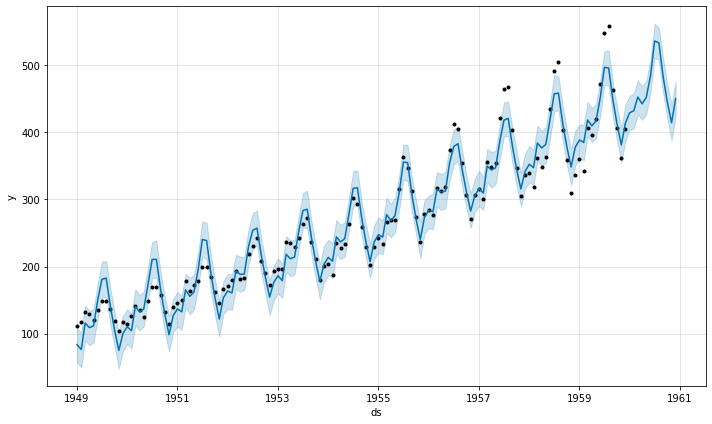

In [400]:
trained_prophet_model.plot(prediction_prophet);

- a sazionalidade tá crescendo a cada ano - sazionalidade multiplicativa.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


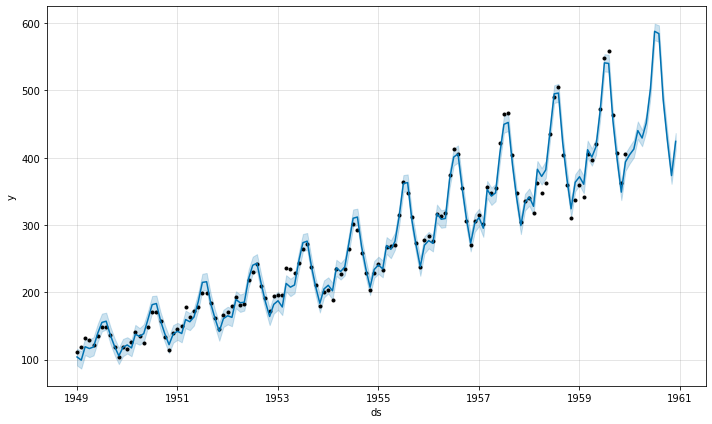

In [404]:
prophet_model_seasonality = Prophet(seasonality_mode='multiplicative')

trained_prophet_model_seasonality = \
    prophet_model_seasonality.fit(passengers_train_prophet)

future_2 = trained_prophet_model_seasonality.make_future_dataframe(periods=12, freq='M')

prediction_model_multiplicative = \
    trained_prophet_model_seasonality.predict(future_2)

trained_prophet_model_seasonality.plot(prediction_model_multiplicative);

### Challenge 04: Make the same for tuberculosis dataset.

In [423]:
prophet_model = Prophet()

tuberculosis_train_prophet = \
    (tuberculosis_train.reset_index()
         [['diagnosis_date', 'qty']]
         .copy()
         .rename(columns={'diagnosis_date': 'ds',
                          'qty': 'y'}))

trained_prophet_model_tuberculosis = prophet_model.fit(tuberculosis_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [424]:
future_3 = trained_prophet_model_tuberculosis.make_future_dataframe(periods=12, freq='M')

In [425]:
prophet_prediction_tuberculosis = trained_prophet_model_tuberculosis.predict(future_3)

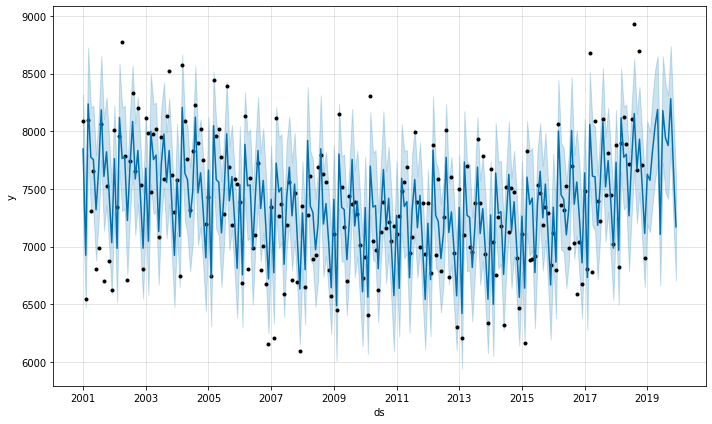

In [427]:
trained_prophet_model_tuberculosis.plot(prophet_prediction_tuberculosis);

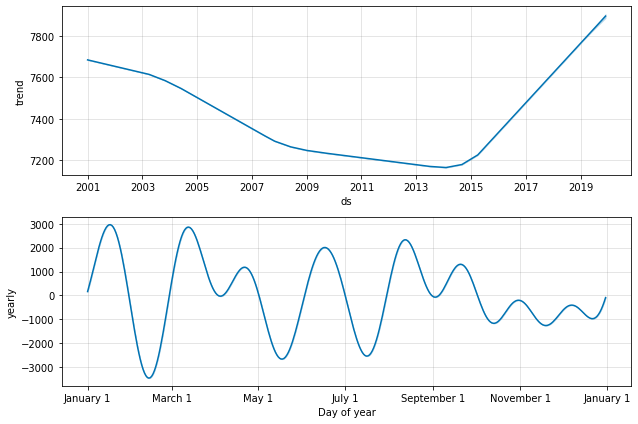

In [428]:
trained_prophet_model_tuberculosis.plot_components(prophet_prediction_tuberculosis);

In [419]:
trained_propet_model_tuberculosis

### Challenge 05: In the graph above, plot the real values together with the predicted ones.

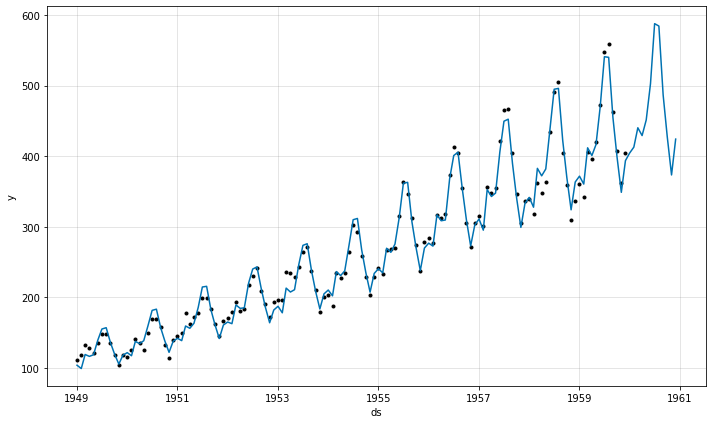

In [436]:
fig = trained_prophet_model_seasonality.plot(prediction_model_multiplicative, 
                                             uncertainty=False,
                                             plot_cap=True)
ax = fig.gca()

https://github.com/facebook/prophet/blob/v0.5/python/fbprophet/plot.py#L42